## A model build using TweetBERT to identify cause-effect pairs in sentences of tweets

The cause-effect pair sentence prediction model will be trained on the dataset which got augmented in an active learning approach in 5 steps.

Load already preprocessed file with sentence containing either cause or effect or both. Sentences labeled as Jokes, questions or having negations are removed.

IO tagging is used instead of BIO tagging. The assumption is that the attention mechanism already encodes information about the postion (B-.). In consequence the training should be simplified with only 3 classes: I-C, I-E, O

In [16]:
import pandas as pd
import numpy as np
import spacy 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from seqeval.metrics import classification_report as classification_report_seqeval
from transformers import BertForSequenceClassification, AutoTokenizer, AutoModelForTokenClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import random
import os
import torch.nn.functional as F
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import transformers
from tqdm import tqdm, trange
from utils import normalizeTweet, split_into_sentences, bio_tagging, EarlyStopping
import matplotlib.pyplot as plt
from ast import literal_eval
from torchcrf import CRF
%matplotlib inline

########################### Check if cuda available ############################
print("Cuda available: ", torch.cuda.is_available())
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')



########################### DATA FILE ###################################
dataPath = "data/cause_effect_sentences_with_IO_tags.csv"
#dataPath = "data/Causality_tweets_data.xlsx"
#dataPath = "Causality_tweets_data.xlsx"


########################### MODEL PARAMETERS ############################
lr = 1e-5 # earlier 1e-3    
adam_eps = 1e-8
epochs = 55
num_warmup_steps = 0
early_patience = 10 # earlier 5, how long to wait after last time validation loss improved

train_batch_size = 8
val_batch_size = 8
test_batch_size = 8
train_to_test_ratio = 0.9 # 10% test and 90% train
val_to_train_ratio = 0.2
type_ = "cause-or-effect"
attempt_ = "test"

bert_model = "vinai/bertweet-base" # "bert-large-uncased"; "roberta-large"

n_labels = 3 # 0, I-C, I-E
tag2id = {label: idx for idx, label in enumerate(["O", "I-C", "I-E"])}
tag2id[-100] = -100
id2tag = {id:tag for tag,id in tag2id.items()}

useClassWeights = True # apply class weights in the model (before the CRF layer)

# Options: https://pytorch-crf.readthedocs.io/en/stable/#torchcrf.CRF.forward
# - "sum" : output will be summed over batches
# - "mean" : output will be averaged over batches
# - "token_mean" : output will be averaged over tokens
# - None : no reduction
reduction_crf = "sum" 

# if True, only sentences containing both cause and effect are considered.
# if False, all sentences containing either cause or effect are considered
requireCauseAndEffect = True 

# Each token has its associated IO tag ("O", "I-C", "I-E").
# The Bertweet tokenizer splits words into sub-words
# if True => assign IO tag of word to all sub-words
# if False => assign IO tag of word to first sub-word and all other sub-words get -100 (loss function ignores this index)
subwordTagEqualFirstwordTag = False # @Vivek : keep it on False

metric_choice = "weighted" # micro, macro, samples or weighted 
# metrics_average = "binary" # this will give measure for class_1,i.e., causal class

# saveModelName = "./model-causal-span/cause-and-effect_model_1_finetuned-{}-epochs-lr_{}.pth".format(epochs, lr) # it should be epoch so that the name shows at what epoch teh mdel ws saved

Cuda available:  False


In [2]:
##### DATA TO LOAD ######

data = pd.read_csv(dataPath, sep=";", converters={"tokenized":literal_eval, "bio_tags":literal_eval})
print(data.shape)
data.head()

(2500, 7)


,sentence,Intent,Cause,Effect,Causal association,tokenized,bio_tags
0,USER Additionally the medicines are being char...,NaN,medicines are being charged at MRP,costing much higher,1.0,"[USER, Additionally, the, medicines, are, bein...","[O, O, O, I-C, I-C, I-C, I-C, I-C, I-C, O, O, ..."
1,"I hear "" I hate being a diabetic "" .",NaN,diabetic,hate,1.0,"[I, hear, "", I, hate, being, a, diabetic, "", .]","[O, O, O, O, I-E, O, O, I-C, O, O]"
2,"i got lime for my glucose test , was n't that ...",NaN,glucose test,nauseous,1.0,"[i, got, lime, for, my, glucose, test, ,, was,...","[O, O, O, O, O, I-C, I-C, O, O, O, O, O, O, O,..."
3,Sounds like Willow 's blood sugar level is rea...,NaN,blood sugar level is real low,reduce her insulin shots,1.0,"[Sounds, like, Willow, 's, blood, sugar, level...","[O, O, O, O, I-C, I-C, I-C, I-C, I-C, I-C, O, ..."
4,USER I 've always found it too sweet mustvsay ...,NaN,dreaded diabetes,sauces are used sparingly,1.0,"[USER, I, 've, always, found, it, too, sweet, ...","[O, O, O, O, O, O, O, O, O, O, O, O, I-E, I-E,..."


## Preprocessing

In [3]:
############ Choose only sentences with both cause and effect or only sentences with either cause or effect (or both) #######


if requireCauseAndEffect: # cause and effect in sentence
    dataSentFiltered = data[(data["Cause"].notnull()) & (data["Effect"].notnull())]
else: # cause or effect or both in sentence
    dataSentFiltered = data[(data["Cause"].notnull()) | (data["Effect"].notnull())]

print(dataSentFiltered.shape)
dataSentFiltered.head()

(2118, 7)


,sentence,Intent,Cause,Effect,Causal association,tokenized,bio_tags
0,USER Additionally the medicines are being char...,NaN,medicines are being charged at MRP,costing much higher,1.0,"[USER, Additionally, the, medicines, are, bein...","[O, O, O, I-C, I-C, I-C, I-C, I-C, I-C, O, O, ..."
1,"I hear "" I hate being a diabetic "" .",NaN,diabetic,hate,1.0,"[I, hear, "", I, hate, being, a, diabetic, "", .]","[O, O, O, O, I-E, O, O, I-C, O, O]"
2,"i got lime for my glucose test , was n't that ...",NaN,glucose test,nauseous,1.0,"[i, got, lime, for, my, glucose, test, ,, was,...","[O, O, O, O, O, I-C, I-C, O, O, O, O, O, O, O,..."
3,Sounds like Willow 's blood sugar level is rea...,NaN,blood sugar level is real low,reduce her insulin shots,1.0,"[Sounds, like, Willow, 's, blood, sugar, level...","[O, O, O, O, I-C, I-C, I-C, I-C, I-C, I-C, O, ..."
4,USER I 've always found it too sweet mustvsay ...,NaN,dreaded diabetes,sauces are used sparingly,1.0,"[USER, I, 've, always, found, it, too, sweet, ...","[O, O, O, O, O, O, O, O, O, O, O, O, I-E, I-E,..."


(array([137., 494., 672., 402., 179., 115.,  79.,  30.,   9.,   1.]),
 array([ 3. , 10.2, 17.4, 24.6, 31.8, 39. , 46.2, 53.4, 60.6, 67.8, 75. ]),
 <BarContainer object of 10 artists>)

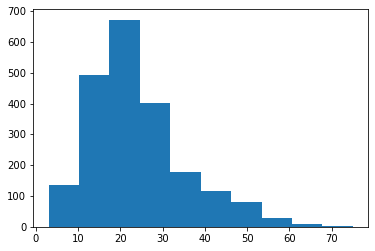

In [4]:
########## Distribution of sentences length ########################

# get length of all the messages in the train set
seq_len = [len(i.split()) for i in dataSentFiltered["sentence"]]
plt.hist(seq_len)
#pd.Series(seq_len).hist(bins = 30)

## Training

In [5]:
trainingDataSample = dataSentFiltered#.sample(n=100)   # Only for testing
train = trainingDataSample.sample(frac=train_to_test_ratio, random_state=0)
test = trainingDataSample.drop(train.index)
validate = train.sample(frac=val_to_train_ratio, random_state=0)
train = train.drop(validate.index)
print("Train:", train.shape)
print("Validate:", validate.shape)
print("Test:", test.shape)

Train: (72, 7)
Validate: (18, 7)
Test: (10, 7)


In [12]:
######### BERTWEET TOKENIZER + PYTORCH DATASET/DATALOADER STRUCTURE ##################

class TweetDataSet(torch.utils.data.Dataset):
    def __init__(self, text, labels, bio_tags, tokenizer):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer
        self.bio_tags = bio_tags


    def __getitem__(self, idx):
        inputs = self.tokenizer(self.text, padding=True, truncation=True, return_token_type_ids=True)
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]     
        bio_tags_extended = self.extend_tags(self.text[idx], self.bio_tags[idx], ids[idx])

        assert len(ids[idx]) == len(bio_tags_extended), "token ids (N: {}) and IO tags (N: {}) lengths do not match!\nids[idx]: {}\nbio_tags: {}".format(len(ids[idx]), len(bio_tags_extended), ids[idx], bio_tags_extended)
        return {
                "input_ids" : torch.tensor(ids[idx], dtype=torch.long)
              , "attention_mask" : torch.tensor(mask[idx], dtype=torch.long)
              , "token_type_ids" : torch.tensor(token_type_ids[idx], dtype=torch.long)
              , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
              , "bio_tags" : torch.tensor(list(map(lambda bioTags: tag2id[bioTags], bio_tags_extended))
, dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)

    
    def extend_tags(self, tokens_old, tags_old, ids_tokenized_padded):
        """ 
            Each token has a IO tag label. 
            However BERT's tokenization splits tokens into subwords. How to label those subwords?
            
            Option 1:
            ---------
            
            add the same label to each subword than the first subword
            Ex. 
            #lowbloodsugar => '#low@@', 'blood@@', 'sugar@@'
               "I-C"       =>   "I-C" ,   "I-C"  ,   "I-C"
            
            Option 2:      
            ---------
            
            From : https://huggingface.co/transformers/custom_datasets.html#token-classification-with-w-nut-emerging-entities
            A common obstacle with using pre-trained models for token-level classification: many of the tokens in
            the W-NUT corpus are not in DistilBert’s vocabulary. Bert and many models like it use a method called 
            WordPiece Tokenization, meaning that single words are split into multiple tokens such that each token
            is likely to be in the vocabulary. For example, DistilBert’s tokenizer would split the Twitter 
            handle @huggingface into the tokens ['@', 'hugging', '##face']. This is a problem for us because we 
            have exactly one tag per token. If the tokenizer splits a token into multiple sub-tokens, then we will
            end up with a mismatch between our tokens and our labels.

            One way to handle this is to only train on the tag labels for the first subtoken of a split token. 
            We can do this in 🤗 Transformers by setting the labels we wish to ignore to -100. 
            In the example above, if the label for @HuggingFace is 3 (indexing B-corporation), we would set 
            the labels of ['@', 'hugging', '##face'] to [3, -100, -100].
        """
        tags = [-100] # add for start token <CLS>
        for token_old, tag in zip(tokens_old.split(" "), tags_old):
            #print(F"\ntoken_old: {token_old};    tag: {tag}")
            for i, sub_token in enumerate(self.tokenizer.tokenize(token_old)):
                if (i == 0): # first sub token of a word keeps the original bio tag
                    firstTag = tag
                    tags.append(tag)
                    #print(F"\tsubToken: {sub_token};    tag: {tag}")
                else: 
                    if subwordTagEqualFirstwordTag: # the other sub tokens get the first bio tag than the first sub token
                        tags.append(firstTag)
                    #    print(F"\tsubToken: {sub_token};    tag: {firstTag}")
                    else: # to other sub tokens get the tag -100 (ignored in loss function)
                        tags.append(-100)
                    #    print(F"\tsubToken: {sub_token};    tag: {-100}")

        tags.append(-100) # 0 for end of sentence token
    
        # append -100 for all padded elements
        padded_elements = ids_tokenized_padded.count(1) # id 1 is <PAD> ; Alternative: where attention_mask == 0 add -100
        tags.extend([-100]*padded_elements)
        #print("\tpadded_elements:", ids_tokenized_padded.count(1))
        return tags
        
        
    
tokenizer = AutoTokenizer.from_pretrained(bert_model, padding = "max_length", truncation = True, max_length = 60 )


train_dataset = TweetDataSet(train["sentence"].values.tolist()
                           , train["Causal association"].values.tolist()
                           , train["bio_tags"].values.tolist()
                           , tokenizer)
val_dataset = TweetDataSet(validate["sentence"].values.tolist()
                           , validate["Causal association"].values.tolist()
                           , validate["bio_tags"].values.tolist()
                           , tokenizer)
test_dataset = TweetDataSet(test["sentence"].values.tolist()
                           , test["Causal association"].values.tolist()
                           , test["bio_tags"].values.tolist()
                           , tokenizer)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# put data to batches
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


72
18
10


In [13]:
############ class weights #####################

# Since -100 will anyway be ignored by loss func, drop it
train_bio_tags = np.hstack([t["bio_tags"][t["bio_tags"]!=-100].numpy() for t in train_dataset])
print("train_bio_tags:", train_bio_tags)

train_bio_tags_count_info = (pd.Series(train_bio_tags).value_counts(normalize=True))
print("train_bio_tags_count_info:", train_bio_tags_count_info)

# for class-imbalanced dataset, the class weight for a ith class
# to be specified for balancing in the loss function is given by:
# weight[i] = num_samples / (num_classes * num_samples[i])
# since train_bio_tags_count_info obtained above has fraction of 
# samples for ith class, hence the corresponding weight calculation is:
class_weight = (1/train_bio_tags_count_info)/len(train_bio_tags_count_info)
class_weight = class_weight[sorted(class_weight.index)]
class_weight


<ipython-input-12-a7b5e9115285>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


train_bio_tags: [0 0 0 ... 0 0 0]
train_bio_tags_count_info: 0    0.802673
1    0.104392
2    0.092934
dtype: float64


0    0.415279
1    3.193089
2    3.586758
dtype: float64

## Evaluation metrics

In [14]:
def compute_metrics(pred, labels):
    """
        Dataset is unbalanced -> measure weighted metrics
        Calculate metrics for each label, and find their average wieghted by support (Number of true instances for each label)
        This alters 'macro' to account for label imbalance;
        it can result in an F-Score taht is not between precision and recall
    """
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average= metric_choice) # TODO: check weightin
    acc = accuracy_score(labels, pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


## Model definition

In [21]:
class CausalNER(torch.nn.Module):
    """ Model Bert"""
    def __init__(self):
        super(CausalNER, self).__init__()
        self.bert = transformers.BertModel.from_pretrained("vinai/bertweet-base")
        self.dropout = torch.nn.Dropout(0.3)
        self.linear1 = torch.nn.Linear(768, 256)
        self.linear2 = torch.nn.Linear(256, n_labels)
        self.softmax = torch.nn.Softmax(-1)
        self.crf = CRF(num_tags=n_labels, batch_first=True)
        
    def forward(self, input_ids, attention_mask, token_type_ids, tags=None, mask_tags_without_CLS=None):
#        _, output_1 = self.bert(input_ids, attention_mask = attention_mask, token_type_ids=token_type_ids, return_dict=False) # if output 1 is our cls token
        output_seq, _ = self.bert(input_ids, attention_mask = attention_mask, token_type_ids=token_type_ids, return_dict=False) # if output 1 is our cls token
        output_2 = self.dropout(output_seq)
        output_3 = self.linear1(output_2)
        output_4 = self.dropout(output_3)
        output_5 = self.linear2(output_4)
        #print("\toutput_5:", output_5.shape)
        
        # Add class weights on logits before the CRF layer. It is experimental, based on: https://github.com/kmkurn/pytorch-crf/issues/47
        if useClassWeights:
            output_5 = torch.stack((output_5[:, :, 0] * class_weight[0]
                                    , output_5[:, :, 1] * class_weight[1]
                                    , output_5[:, :, 2] * class_weight[2] ), dim=2)

        if tags is not None:
            # to avoid this error from the pytorch-crf package: ValueError: mask of the first timestep must all be on
            # delete [CLS] token of every phrase and first token of mask.
            tags_without_CLS = torch.cat([tags[i][1:] for i in range(len(tags))]).view(tags.shape[0],-1)
            logits_without_CLS = torch.cat([output_5[i][1:] for i in range(len(output_5))]).view(tags.shape[0],-1,n_labels)
            
            tags_without_CLS[tags_without_CLS==-100] = 0 # replace all -100 by 0. This is a requirement for crf. But by using the mask, those values are ignored anyways
            
            loss = self.crf(emissions=logits_without_CLS, tags=tags_without_CLS, mask=mask_tags_without_CLS)
            sequence_of_tags = self.crf.decode(emissions=logits_without_CLS, mask=mask_tags_without_CLS)
            
            return loss, sequence_of_tags
        else:
            sequence_of_tags = self.crf.decode(output_5)
            return sequence_of_tags


In [18]:
model = CausalNER()
model.to(device)

# fine-tune only the task-specific parameters 
for param in model.bert.parameters():
    param.requires_grad = False
#     param[:-1].requires_grad = False
#     param[-1].requires_grad = True

num_training_steps = np.ceil(len(train_dataset)/train_batch_size)*epochs
optim = AdamW(model.parameters(), lr=lr, eps=adam_eps)
# scheduler with a linearly decreasing learning rate from the initial lr set in the optimizer to 0;
# after a warmup period during which it increases linearly from to the initial lr set in the optimizer
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps) 


## adding weight to the loss function 
#loss_fn = CrossEntropyLoss(
#    weight=torch.tensor(class_weight.to_list()).to(device),
#    ignore_index=-100 # ignore subwords/tokens with label -100 
#)

#loss_fn = CrossEntropyLoss(ignore_index=-100)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['roberta.encoder.layer.7.attention.self.value.bias', 'roberta.encoder.layer.6.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.6.output.dense.weight', 'roberta.encoder.layer.6.attention.self.query.weight', 'roberta.encoder.layer.0.attention.self.query.weight', 'roberta.encoder.layer.9.output.dense.bias', 'roberta.pooler.dense.weight', 'roberta.encoder.layer.0.attention.self.query.bias', 'roberta.encoder.layer.5.attention.output.LayerNorm.bias', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.1.attention.self.query.weight', 'roberta.encode

Some weights of BertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['embeddings.LayerNorm.bias', 'encoder.layer.5.output.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.5.attention.self.value.bias', 'encoder.layer.8.attention.output.dense.weight', 'encoder.layer.3.attention.self.query.weight', 'encoder.layer.8.attention.output.LayerNorm.bias', 'encoder.layer.10.attention.self.key.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.3.attention.output.LayerNorm.weight', 'encoder.layer.3.output.dense.weight', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.2.attention.self.key.weight', 'encoder.layer.2.attention.self.query.bias', 'encoder.layer.5.intermediate.dense.bias', 'encoder.layer.8.attention.self.value.weight', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.output.LayerNor

In [19]:
################ TRAINING ######################

# initialise the early_stopping object
early_stopping = EarlyStopping(patience=early_patience, verbose=True)

train_avg_loss = [] # avg training loss per epoch
val_avg_loss = [] # avg validation loss per epoch
train_avg_acc = [] # avg training accuracy per epoch
val_avg_acc = [] # avg val accuracy per epoch
n_trained_epochs = 0

for epoch in trange(1, epochs+1, desc='Epoch'):
    print("<" + "="*22 + F" Epoch {epoch} "+ "="*22 + ">")

    
    ############ training eval metrics ######################
    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    train_f1 = []
    
    #########################################################
    
    
    for batch in tqdm(train_loader):
        optim.zero_grad() # gradients get accumulated by default -> clear previous accumulated gradients
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch['labels'].to(device)
        bio_tags = batch['bio_tags'].to(device)
        
        # crf in model requires to start with a positive mask label => ignore first token [CLS]
        bio_tags_without_CLS = torch.cat([bio_tags[i][1:] for i in range(len(bio_tags))]).view(bio_tags.shape[0],-1)
        mask_tags_without_CLS = torch.cat([bio_tags[i][1:] != -100 for i in range(len(bio_tags))]).view(bio_tags.shape[0],-1).byte().to(device) # byte() casts boolean tensor to tensor with 1 and 0 


        ################################################
        model.train() # set model to training mode
#        logits = model(**{"input_ids":input_ids, "attention_mask":attention_mask, "token_type_ids":token_type_ids}) # forward pass
        log_likelihood, sequence_of_tags = model(**{"input_ids":input_ids
                        , "attention_mask":attention_mask
                        , "token_type_ids":token_type_ids
                        , "tags":bio_tags
                        , "mask_tags_without_CLS":mask_tags_without_CLS}) # forward pass        

        ################################################ 
        loss = -1 * log_likelihood           
        print("loss:", loss)     
        loss.backward() # backward pass
        ## gradient clipping to control the exploding gradient problem 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optim.step()    # update parameters and take a steup using the computed gradient
        scheduler.step()# update learning rate scheduler
        train_loss.append(loss.item())
        
    

        ################## Training Performance Measures ##########
        bio_tags_without_CLS = bio_tags_without_CLS.detach().to("cpu").numpy()
        mask_tags_without_CLS = mask_tags_without_CLS.detach().to("cpu").numpy()
        
        tags_ids = bio_tags.to('cpu').numpy()
        true_tags = bio_tags_without_CLS[mask_tags_without_CLS.astype(bool)] # get Bio tags for tokens only
        pred = [item for elem in sequence_of_tags for item in elem] # flatten list of lists

        metrics = compute_metrics(pred, true_tags)
        train_acc.append(metrics["accuracy"])
        train_prec.append(metrics["precision"])
        train_rec.append(metrics["recall"])
        train_f1.append(metrics["f1"])
                          
    train_avg_loss.append(np.mean(train_loss))
    train_avg_acc.append(np.mean(train_acc))           
    print(F'\n\tTraining Loss: {np.mean(train_loss)}')
    print(F'\n\tTraining acc: {np.mean(train_acc)}')
    print(F'\n\tTraining prec: {np.mean(train_prec)}')
    print(F'\n\tTraining rec: {np.mean(train_rec)}')
    print(F'\n\tTraining f1: {np.mean(train_f1)}')

    n_trained_epochs += 1

                          
    ###################################################################################

    
    ## ---- Validation ------    
    val_accuracy = []
    val_loss = []
    val_acc = []
    val_prec = []
    val_rec = []
    val_f1 = []

    # Evaluate data for one epoch
    for batch in tqdm(validation_loader):
        batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
        v_input_ids, v_input_mask, v_token_type_ids, v_labels, v_bio_tags = batch  # unpack inputs from dataloader

        # crf in model requires to start with a positive mask label => ignore first token [CLS]
        v_mask_tags_without_CLS = torch.cat([v_bio_tags[i][1:] != -100 for i in range(len(v_bio_tags))]).view(v_bio_tags.shape[0],-1).byte() # byte() casts boolean tensor to tensor with 1 and 0         
        v_bio_tags_without_CLS = torch.cat([v_bio_tags[i][1:] for i in range(len(v_bio_tags))]).view(v_bio_tags.shape[0],-1)
   
        with torch.no_grad(): # tell model not to compute or store gradients -> saves memory + speeds up validation
            model.eval() # put model in evaluation mode for validation set
            #logits = model(**{"input_ids":v_input_ids, "attention_mask":v_input_mask, "token_type_ids":v_token_type_ids}) # forward pass, calculates logit predictions
            log_likelihood, sequence_of_tags = model(**{"input_ids":v_input_ids
                                                    , "attention_mask":v_input_mask
                                                    , "token_type_ids":v_token_type_ids
                                                    , "tags": v_bio_tags
                                                    , "mask_tags_without_CLS":v_mask_tags_without_CLS}) # forward pass, calculates logit predictions
        ######################################################
          
        v_loss = -1 * log_likelihood        
        val_loss.append(v_loss.item())
              
        #########################################################
        # calculate performance measures only on tokens and not subwords or special tokens       
        v_bio_tags_without_CLS = v_bio_tags_without_CLS.detach().to("cpu").numpy()
        v_mask_tags_without_CLS = v_mask_tags_without_CLS.detach().to("cpu").numpy()
        #sequence_of_tags = sequence_of_tags.detach().to("cpu").numpy()
        
        true_tags = v_bio_tags_without_CLS[v_mask_tags_without_CLS.astype(bool)] # get Bio tags for tokens only
        pred = [item for elem in sequence_of_tags for item in elem] # flatten list of lists
        
        metrics = compute_metrics(pred, true_tags)
        val_acc.append(metrics["accuracy"])
        val_prec.append(metrics["precision"])
        val_rec.append(metrics["recall"])
        val_f1.append(metrics["f1"])
                              
    val_avg_loss.append(np.mean(val_loss))
    val_avg_acc.append(np.mean(val_acc))        
    print(F'\n\tValidation Loss: {np.mean(val_loss)}')
    print(F'\n\tValidation acc: {np.mean(val_acc)}')
    print(F'\n\tValidation prec: {np.mean(val_prec)}')
    print(F'\n\tValidation rec: {np.mean(val_rec)}')
    print(F'\n\tValidation f1: {np.mean(val_f1)}')

    # early_stopping needs the validation loss to check if it has decreased,
    # and if it has, it will make a checkpoint of the current model
    saveModelName = "./model-causal-span/{}_model_{}_finetuned-{}-epochs-lr_{}.pth".format(type_, attempt_, n_trained_epochs-early_patience, lr) 
    early_stopping.path = saveModelName
    early_stopping(np.average(val_loss), model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break


  0%|          | 0/9 [00:00<?, ?it/s]<ipython-input-12-a7b5e9115285>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


<====================== Epoch 1 ======================>



 11%|█         | 1/9 [00:00<00:05,  1.57it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 3.1688e-02,  1.1323e+00, -1.2428e+00],
         [-9.2115e-02,  2.0119e-01, -1.8430e+00],
         [ 2.4658e-01, -6.3110e-01,  6.0676e-01],
         ...,
         [-2.7256e-01, -9.0704e-01, -1.7028e+00],
         [-2.8203e-02,  6.6730e-01, -1.1917e+00],
         [ 9.8463e-02, -8.7828e-01, -1.2588e+00]],

        [[-2.8947e-01, -1.0662e+00, -2.2454e+00],
         [ 1.5229e-01, -1.7752e+00, -1.5391e+00],
         [-5.4367e-03, -1.4074e+00, -2.1924e+00],
         ...,
         [ 3.7107e-01, -1.0555e+00, -2.2964e-03],
         [-1.2744e-01, -1.4888e+00, -1.5369e+00],
         [-4.4083e-02, -1.5029e+00, -1.3485e+00]],

        [[-2.2584e-01,  1.2221e+00, -1.2360e+00],
         [ 2.7887e-01, -2.7550e+00, -2.1472e+00],
         [ 9.3733e-02,  2.1720e+00, -1.5523e+00],
         ...,
         [-1.8945e-01, -5.6375e-01, -3.0436e+00],
         [ 1.6819e-01, -8.9354e-01,  1.1197e-01],
         [ 1.4772e-01, -3.0119e-01,  8.3386e-01]],

        ...,

    


 22%|██▏       | 2/9 [00:01<00:04,  1.49it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-1.5659e-01, -8.3264e-01, -1.4897e+00],
         [ 9.4517e-02,  1.4556e+00, -2.5718e+00],
         [ 4.1358e-01, -1.1324e+00,  3.2143e-01],
         ...,
         [-9.5965e-02, -2.0463e+00,  2.2768e+00],
         [ 4.9940e-04, -7.3650e-01,  7.0503e-01],
         [-1.9877e-01, -3.2915e+00, -1.6557e+00]],

        [[-2.7292e-01,  7.1966e-01, -1.3775e+00],
         [-1.4219e-01, -1.4855e+00, -1.8994e+00],
         [-1.9337e-01, -1.4460e+00, -1.6227e+00],
         ...,
         [ 2.1438e-01, -1.0373e+00,  1.9979e+00],
         [-9.1732e-02,  1.2342e+00,  4.3663e-01],
         [ 4.3413e-02, -8.7657e-01,  2.3486e+00]],

        [[-1.5766e-01,  7.4259e-01, -3.6344e+00],
         [-1.5118e-01, -1.5837e+00,  1.2047e+00],
         [ 1.9540e-01, -5.7568e-01, -1.4947e+00],
         ...,
         [-3.6083e-01, -8.0543e-01, -3.2209e-01],
         [-2.6438e-01, -1.8469e+00,  2.3069e+00],
         [ 4.8551e-02, -2.4643e+00,  1.8674e+00]],

        ...,

    


 33%|███▎      | 3/9 [00:02<00:04,  1.46it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 2.3177e-01, -1.5627e+00, -1.9007e+00],
         [-3.8122e-02,  3.3159e-01, -3.7635e-01],
         [-1.0711e-01,  1.8681e+00, -2.1561e+00],
         ...,
         [ 1.1428e-01, -2.7211e+00,  3.8584e-01],
         [ 2.6234e-02,  1.3459e+00, -9.8879e-01],
         [ 2.5410e-03,  6.9595e-01,  2.3998e-01]],

        [[-8.3244e-02,  2.6950e-02, -1.8695e+00],
         [-1.1916e-01, -5.9731e-01, -4.2394e-01],
         [-4.7130e-02, -3.9399e-01, -2.0570e+00],
         ...,
         [-2.3525e-01, -1.7073e+00,  5.2792e-01],
         [-1.1944e-02,  1.2459e+00, -3.7864e+00],
         [ 9.8840e-02, -2.9936e-02,  2.6172e-01]],

        [[-4.9339e-03,  3.8179e-01, -2.0196e+00],
         [-5.0515e-02, -5.4086e-01, -1.3208e+00],
         [ 1.0959e-02,  5.0807e-01, -1.9956e+00],
         ...,
         [ 1.4729e-01, -3.0589e+00, -7.2558e-01],
         [ 2.3552e-02, -9.3664e-01,  1.2051e+00],
         [ 2.5567e-03, -1.5921e+00, -2.4942e+00]],

        ...,

    


 44%|████▍     | 4/9 [00:02<00:03,  1.52it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-2.9489e-02, -9.2304e-01, -2.2518e+00],
         [ 1.2461e-01, -5.9648e-01, -1.9624e+00],
         [-1.9970e-01, -1.3918e-01, -1.7362e+00],
         ...,
         [-8.8661e-02, -9.5419e-01,  1.5568e+00],
         [-1.1375e-01,  1.6186e-01, -2.5925e+00],
         [-5.3972e-02, -1.0139e+00, -1.4005e+00]],

        [[-5.4652e-02,  1.6708e+00, -1.6361e+00],
         [ 1.0618e-01,  9.1220e-01, -1.9565e+00],
         [ 1.2838e-01, -1.7642e-01, -1.3367e+00],
         ...,
         [-1.2301e-01, -2.4347e+00,  1.2786e+00],
         [ 1.7760e-03,  1.1753e+00, -9.4898e-01],
         [-1.5898e-01, -8.5475e-01, -2.1002e+00]],

        [[-6.6534e-02,  1.8460e-01, -2.1405e+00],
         [ 2.0051e-01, -1.6388e-01, -3.2084e+00],
         [-4.0383e-02, -2.6791e+00,  3.0865e-01],
         ...,
         [-3.6449e-01, -2.7235e+00,  1.2663e+00],
         [-9.9849e-02, -1.2694e+00, -1.1339e+00],
         [ 1.0140e-01,  1.1524e-01,  2.4329e-01]],

        ...,

    


 56%|█████▌    | 5/9 [00:03<00:02,  1.48it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-1.8230e-04,  1.5339e-01, -2.6521e+00],
         [-3.8170e-04, -1.7048e+00, -5.5682e-01],
         [ 2.4457e-01, -3.9877e+00, -1.7093e+00],
         ...,
         [-1.0725e-01, -1.8577e+00,  1.1845e+00],
         [-1.0240e-01, -1.5178e+00,  1.3154e+00],
         [-3.4446e-01, -1.4928e+00, -1.2490e-01]],

        [[ 7.2935e-02, -6.6152e-01, -5.9370e-01],
         [ 1.3198e-02, -2.7343e-02, -3.5457e-01],
         [ 1.1275e-01,  5.9060e-01, -9.3777e-01],
         ...,
         [-1.4918e-01, -2.2495e+00, -1.3311e+00],
         [ 1.8747e-02, -1.1811e+00,  9.9304e-01],
         [-1.4327e-01, -2.0833e+00, -1.3147e+00]],

        [[-9.7404e-02,  5.0761e-02, -1.0401e+00],
         [ 6.5127e-03, -8.0430e-01, -1.3585e+00],
         [ 9.2427e-02, -1.1337e-01,  2.1303e-01],
         ...,
         [-5.4490e-02, -1.5443e+00,  6.7442e-01],
         [ 1.6074e-01, -1.1216e+00, -1.5514e+00],
         [-3.0058e-01, -1.9021e+00, -9.2725e-01]],

        ...,

    


 67%|██████▋   | 6/9 [00:03<00:01,  1.52it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-0.0921, -1.0202, -0.9742],
         [-0.1317,  0.3678, -1.1130],
         [ 0.0702, -2.3998, -2.1868],
         ...,
         [-0.0217, -0.3071,  0.2012],
         [-0.2137, -0.8210, -0.1894],
         [ 0.2128,  0.0371,  0.8520]],

        [[ 0.0559,  0.4186, -0.1078],
         [-0.1199,  0.6473, -0.6441],
         [-0.2089,  0.8640,  0.1759],
         ...,
         [ 0.0711, -3.4383, -0.6331],
         [-0.0120,  1.2040,  0.1901],
         [ 0.1297, -2.8550,  2.7507]],

        [[-0.3912, -2.1923, -0.4548],
         [ 0.0061, -0.5332,  2.7440],
         [-0.0539, -1.9076, -2.6684],
         ...,
         [-0.0710,  0.0170,  1.8617],
         [-0.1679, -0.8010, -0.6439],
         [ 0.0823,  0.0877, -0.8053]],

        ...,

        [[-0.0150,  1.4905, -1.7436],
         [ 0.2336, -0.3289,  0.7652],
         [-0.1072,  0.9710, -2.3145],
         ...,
         [-0.0416,  0.6985,  0.2951],
         [-0.2965, -2.2319,  0.0916],
         [-0.084


 78%|███████▊  | 7/9 [00:04<00:01,  1.51it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-2.4195e-01, -9.6475e-01,  1.1806e+00],
         [-1.4692e-01, -8.6783e-02, -1.5882e+00],
         [ 1.8072e-01,  1.0580e-01,  1.5735e+00],
         ...,
         [ 1.9748e-01, -2.4769e+00, -6.0015e-01],
         [-3.9520e-02,  4.8684e-01,  1.6533e+00],
         [-9.4815e-02, -1.1614e+00, -2.1497e+00]],

        [[ 2.6242e-01, -6.0767e-01, -1.8347e+00],
         [ 1.6960e-01,  3.0886e-01, -3.2381e-01],
         [-1.0445e-01, -1.8661e-01, -2.6190e+00],
         ...,
         [ 1.9260e-01, -2.0190e+00,  4.5864e-01],
         [-5.9340e-02, -1.2880e+00, -2.1294e+00],
         [-3.5399e-03, -1.7825e+00, -2.8489e+00]],

        [[-1.1070e-02, -2.2511e+00, -2.3229e+00],
         [ 8.2175e-02, -1.8149e+00, -2.0611e+00],
         [ 1.0866e-01, -4.5588e-01, -8.3085e-01],
         ...,
         [ 1.0074e-01, -2.6767e+00,  1.0554e+00],
         [-1.8087e-01, -4.7329e-02,  6.3185e-02],
         [-4.4125e-01, -5.0966e-01, -4.9372e-02]],

        ...,

    


 89%|████████▉ | 8/9 [00:05<00:00,  1.51it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-0.1603, -0.9000, -2.7521],
         [-0.1210, -0.5594, -1.8801],
         [ 0.2918, -0.8608, -2.4318],
         ...,
         [-0.2268,  0.2180,  3.8067],
         [ 0.3154, -1.6499, -1.3634],
         [ 0.0852,  0.1492,  1.6858]],

        [[-0.1978,  1.5022, -2.9118],
         [-0.1905, -2.6112, -2.2710],
         [-0.0708, -0.5629, -0.3005],
         ...,
         [-0.1068, -0.3127, -0.1032],
         [ 0.0586,  0.1267, -1.2113],
         [ 0.1497, -1.1471, -0.9444]],

        [[-0.0766, -0.2237, -2.3981],
         [ 0.0537, -1.9635, -0.5263],
         [ 0.2149, -2.1442, -0.9375],
         ...,
         [ 0.2796, -0.7420,  2.5404],
         [-0.1302, -2.4607, -0.9579],
         [-0.1819, -2.2352, -1.8790]],

        ...,

        [[-0.1121, -0.2881, -1.5680],
         [ 0.3402, -1.6424,  1.3853],
         [ 0.0883, -0.9487,  0.9417],
         ...,
         [ 0.1603, -1.6442, -0.2541],
         [ 0.1332,  0.5219, -0.7566],
         [ 0.176


100%|██████████| 9/9 [00:06<00:00,  1.49it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-3.4367e-01, -7.2795e-01, -2.2530e+00],
         [ 3.6332e-02, -2.3267e+00, -1.4296e+00],
         [ 2.0852e-01,  6.2073e-01, -3.7288e-01],
         ...,
         [-1.9462e-01, -3.3172e-01,  6.5490e-01],
         [ 2.7683e-01,  7.6436e-01,  9.3776e-01],
         [-1.3885e-01, -7.4581e-01, -2.4996e+00]],

        [[-2.4181e-02,  2.6752e+00, -1.6768e+00],
         [-2.9543e-01,  1.3033e-01, -2.6125e+00],
         [ 1.2868e-02, -9.7043e-01, -1.6354e+00],
         ...,
         [ 1.3055e-01, -1.8210e+00, -6.2356e-01],
         [-4.0339e-02,  7.5131e-02, -5.6935e-01],
         [ 3.4765e-02, -4.7727e-01, -2.7210e+00]],

        [[ 2.1811e-02, -1.1640e-01, -4.4829e+00],
         [ 2.1569e-01, -1.8322e+00,  1.3124e+00],
         [ 2.6129e-01, -1.9452e+00, -1.4751e+00],
         ...,
         [-1.9404e-02, -1.9656e+00, -2.1924e+00],
         [ 1.5209e-01, -9.0515e-01, -1.5737e+00],
         [ 1.4714e-02, -9.3388e-01, -8.2544e-02]],

        ...,

    


 33%|███▎      | 1/3 [00:00<00:01,  1.71it/s]

	output_5: torch.Size([8, 52, 3])
tensor([[[-0.0357, -0.5240, -2.6592],
         [-0.0460, -0.9456, -0.7712],
         [ 0.0858, -0.8549, -2.0832],
         ...,
         [-0.0171, -0.0640, -2.0459],
         [ 0.0706, -1.2696, -2.3720],
         [ 0.1472, -1.6287, -1.4654]],

        [[-0.0515, -0.4812, -2.1623],
         [-0.0296, -1.1627, -0.9841],
         [ 0.0390, -1.1512, -0.8067],
         ...,
         [-0.0314, -0.1395, -1.4503],
         [ 0.0586, -1.2518, -2.0148],
         [ 0.1355, -1.5639, -1.0414]],

        [[-0.0793, -0.2926, -2.5871],
         [-0.0635, -0.6447, -1.2276],
         [ 0.0157, -0.0210, -1.0980],
         ...,
         [-0.0547,  0.0926, -2.0013],
         [ 0.0132, -0.9177, -2.5643],
         [ 0.1035, -1.4011, -1.6814]],

        ...,

        [[-0.0568, -0.4403, -1.9658],
         [-0.0382, -1.2228, -0.7364],
         [ 0.0169, -1.0072, -0.6070],
         ...,
         [-0.0420, -0.1067, -1.3861],
         [ 0.0413, -1.1305, -1.8795],
         [ 0.104


 67%|██████▋   | 2/3 [00:01<00:00,  1.76it/s]

	output_5: torch.Size([8, 52, 3])
tensor([[[-0.0825, -0.2885, -2.1126],
         [-0.0597, -1.3132, -0.9991],
         [ 0.0196, -0.5953, -2.3618],
         ...,
         [-0.0701,  0.0256, -1.5738],
         [ 0.0204, -1.0410, -2.0519],
         [ 0.0917, -1.3479, -1.1934]],

        [[-0.0593, -0.6370, -2.2415],
         [-0.0354, -1.2735, -1.0645],
         [ 0.0362, -1.0109, -0.9140],
         ...,
         [-0.0297, -0.1035, -1.6712],
         [ 0.0482, -1.2602, -2.0781],
         [ 0.1234, -1.5748, -1.2108]],

        [[-0.0491, -0.3955, -2.3514],
         [ 0.0557, -0.8915, -1.2771],
         [-0.0058, -0.6240, -1.5541],
         ...,
         [-0.0172,  0.0520, -1.6634],
         [ 0.0545, -1.1365, -2.1205],
         [ 0.1298, -1.5216, -1.1061]],

        ...,

        [[-0.0902, -0.3929, -2.2526],
         [ 0.0075, -1.6491, -1.8501],
         [ 0.0240, -1.7011, -1.9952],
         ...,
         [-0.0738,  0.0238, -1.8524],
         [-0.0027, -1.1197, -2.2587],
         [ 0.071

/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

	output_5: torch.Size([2, 52, 3])
tensor([[[-7.1888e-02, -7.1540e-01, -2.2732e+00],
         [ 1.8174e-01, -1.1189e+00, -1.3727e+00],
         [ 1.2167e-01, -1.2622e+00, -2.0568e+00],
         [ 3.9053e-02, -1.9606e+00, -7.2530e-01],
         [-1.7627e-02, -1.8541e+00, -1.3036e+00],
         [-6.7319e-02, -2.5202e+00, -2.6446e+00],
         [ 1.2939e-02, -1.7756e+00, -1.2018e+00],
         [-5.1207e-02, -1.4651e+00, -2.5603e+00],
         [-3.7260e-02, -1.6765e+00, -3.1978e+00],
         [ 7.3126e-02, -2.7486e+00, -2.5244e+00],
         [ 1.1048e-01, -1.6648e+00, -3.7288e-01],
         [-5.0036e-03, -1.7785e+00, -1.4286e+00],
         [ 7.0309e-03, -1.3929e+00, -1.8457e+00],
         [ 3.8526e-02, -1.9742e+00, -2.4681e+00],
         [-4.0750e-02, -8.2370e-01, -3.2457e-01],
         [ 8.3919e-02, -1.6012e+00, -7.6461e-01],
         [ 1.7383e-01, -1.6850e+00, -2.2974e+00],
         [-1.9895e-02, -7.5924e-01, -2.9229e+00],
         [ 5.2209e-02, -9.6295e-01, -4.0319e-01],
         [-1.154


  0%|          | 0/9 [00:00<?, ?it/s]

<====================== Epoch 2 ======================>



 11%|█         | 1/9 [00:00<00:07,  1.00it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 8.4146e-02, -1.1236e+00, -4.6082e+00],
         [ 2.2214e-01, -1.0488e-01, -2.8118e+00],
         [-1.9893e-01, -1.2342e+00, -1.3614e+00],
         ...,
         [ 1.0926e-01, -1.3828e+00, -3.2274e-01],
         [-6.5724e-03,  4.2385e-02,  2.2221e-01],
         [-3.4821e-01, -6.8840e-01, -1.1216e+00]],

        [[-2.1612e-01,  5.3609e-01, -2.6043e+00],
         [-2.7964e-01, -3.5163e-02, -1.6349e+00],
         [-1.8337e-01,  3.3622e-01, -1.2698e+00],
         ...,
         [-2.0012e-02, -6.1452e-01, -1.1823e+00],
         [-1.8692e-01, -1.6777e-01, -1.6572e+00],
         [ 8.1837e-02, -1.5592e-01, -7.9031e-01]],

        [[-8.3673e-03,  5.8532e-01, -2.6972e+00],
         [-3.1361e-01, -2.6137e-01, -2.0893e+00],
         [-1.6057e-02, -2.0851e+00, -3.0942e-02],
         ...,
         [-1.2095e-01, -2.1190e-01, -2.1847e+00],
         [-1.3648e-02,  5.0390e-01, -9.6361e-01],
         [-3.3128e-02, -2.4428e+00, -2.7919e-02]],

        ...,

    


 22%|██▏       | 2/9 [00:01<00:06,  1.10it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 0.0731,  0.5620, -2.8750],
         [-0.2833, -3.6708, -1.2645],
         [-0.1271,  0.0608, -4.0366],
         ...,
         [-0.2240, -1.6679, -0.4293],
         [-0.0206, -1.6366, -2.3112],
         [ 0.0434, -0.1519, -1.8269]],

        [[-0.1294, -2.9328, -1.3262],
         [ 0.1031, -1.5462, -3.7311],
         [ 0.5576, -3.6159, -0.8538],
         ...,
         [ 0.2094, -3.0833, -0.0443],
         [ 0.2407, -0.4942, -1.1575],
         [-0.2459, -0.6640, -1.1740]],

        [[-0.1482, -0.0201, -3.8553],
         [-0.1684, -1.0374, -2.5913],
         [-0.1272, -2.5686, -1.5484],
         ...,
         [-0.1238, -2.0590, -1.4741],
         [ 0.1671, -2.2989,  0.6521],
         [-0.3857, -2.1026, -0.6733]],

        ...,

        [[-0.1091,  0.3201, -1.3071],
         [ 0.1713, -0.3404,  0.1537],
         [ 0.2921, -0.9967, -2.0329],
         ...,
         [-0.0947, -1.3583, -0.1861],
         [ 0.2910, -1.0251, -0.7507],
         [-0.145


 33%|███▎      | 3/9 [00:02<00:05,  1.17it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-0.0239, -0.7054, -1.1600],
         [-0.0271, -3.1186, -1.9941],
         [ 0.1665, -0.8224, -2.2487],
         ...,
         [-0.3798, -2.0472, -1.5563],
         [ 0.1453, -1.7107, -2.2390],
         [-0.2614, -3.0185, -1.0299]],

        [[ 0.2729, -0.7099, -1.3193],
         [ 0.0860, -2.2626,  1.4416],
         [ 0.0302,  1.1344, -1.5408],
         ...,
         [ 0.0334, -0.3497, -1.9517],
         [ 0.2609,  0.3559,  0.5054],
         [-0.1645, -1.8263, -1.9379]],

        [[ 0.0310, -1.1780,  0.6690],
         [ 0.0248, -0.1684, -0.6955],
         [ 0.0555, -0.1878, -1.5799],
         ...,
         [ 0.0501, -1.4896, -1.1457],
         [ 0.0138, -0.1483, -0.7787],
         [ 0.0078, -3.0914, -0.5875]],

        ...,

        [[-0.2036, -0.2857, -1.6409],
         [-0.2368, -2.6514, -1.4364],
         [ 0.0527, -0.4026, -0.5956],
         ...,
         [-0.0061, -3.7550,  0.7670],
         [ 0.0583,  0.4314, -3.7400],
         [-0.188


 44%|████▍     | 4/9 [00:03<00:03,  1.28it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-2.1395e-01, -1.2654e+00, -2.9512e+00],
         [-1.2474e-01, -1.4250e+00,  3.9412e-01],
         [ 1.0652e-01,  5.9631e-01,  1.0681e-01],
         ...,
         [ 1.3140e-01, -2.0207e+00,  2.1254e-01],
         [-7.4447e-02, -1.3546e+00,  1.2326e-01],
         [ 9.2660e-02, -1.9167e+00, -1.6384e-01]],

        [[-9.0745e-02, -5.2307e-01, -4.2376e+00],
         [ 7.5123e-02, -5.8916e-01,  9.3240e-01],
         [ 3.0023e-01, -1.2288e+00, -3.1955e+00],
         ...,
         [ 2.9994e-01, -1.0385e+00,  5.3260e-01],
         [-5.9878e-02, -2.3071e+00,  1.5384e-01],
         [-1.9509e-02,  3.0416e-01,  1.7595e+00]],

        [[-1.4472e-02, -4.9659e-01, -1.4122e+00],
         [-1.9713e-01, -8.7021e-01,  8.7701e-01],
         [ 4.3682e-03,  1.2338e-01, -1.3936e-01],
         ...,
         [-1.5250e-02, -1.2333e-01, -1.7615e-01],
         [-8.7941e-02, -3.7282e+00, -1.6011e+00],
         [-4.0059e-02, -3.5408e+00, -1.0576e+00]],

        ...,

    


 56%|█████▌    | 5/9 [00:04<00:03,  1.32it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 1.0769e-01, -3.2877e-01, -9.5801e-01],
         [ 2.9835e-02, -8.7831e-01,  6.0361e-02],
         [ 5.7214e-01, -2.7017e+00, -1.2003e+00],
         ...,
         [-9.7029e-02, -5.6505e-01, -2.1297e+00],
         [-2.7666e-01,  7.3329e-02, -1.9529e+00],
         [-3.4620e-01, -8.1513e-01, -1.6978e+00]],

        [[-7.7134e-02,  1.3476e+00, -4.3409e+00],
         [ 2.2153e-01, -1.5946e-01, -3.1365e+00],
         [ 1.0519e-01, -6.2474e-01, -3.6076e+00],
         ...,
         [ 3.2920e-01, -2.8114e+00, -4.5737e-01],
         [ 2.4387e-04, -1.3778e-01, -3.1828e+00],
         [ 1.2396e-01, -2.1792e+00,  6.3679e-02]],

        [[ 4.7442e-02,  3.2968e-01, -3.0404e+00],
         [ 6.9215e-02,  9.9216e-02, -9.2476e-01],
         [ 3.6833e-01, -8.0426e-01, -1.4534e+00],
         ...,
         [-2.6072e-02, -1.1434e+00, -2.3574e+00],
         [-5.6462e-02, -1.3356e-01, -1.8104e+00],
         [-1.1919e-01, -1.3621e+00, -3.5470e-01]],

        ...,

    


 67%|██████▋   | 6/9 [00:04<00:02,  1.34it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-0.4894, -0.6302, -2.9690],
         [-0.0698, -1.6233, -4.5945],
         [-0.1206, -2.1480, -0.9002],
         ...,
         [-0.0254, -1.4537, -2.3948],
         [-0.0227,  1.1042, -2.6441],
         [-0.1249, -0.6998, -3.2517]],

        [[-0.1075,  0.8007, -2.2282],
         [ 0.2063, -2.4605, -0.6563],
         [ 0.0721,  1.1973, -2.3164],
         ...,
         [-0.2194, -2.8098,  0.1670],
         [ 0.3122, -2.8697, -2.1251],
         [-0.2696, -2.7410, -1.5830]],

        [[-0.0239, -1.2681, -2.4816],
         [ 0.2603, -0.8425, -0.7649],
         [-0.0408, -2.8759, -1.4605],
         ...,
         [-0.0323, -3.2352,  0.2455],
         [ 0.2745, -2.5528,  0.7446],
         [-0.0681, -3.3686, -0.8872]],

        ...,

        [[-0.0608, -1.5779, -2.8469],
         [-0.1012,  0.9909, -1.7503],
         [ 0.0062, -1.4272, -3.0552],
         ...,
         [ 0.0464, -0.5422, -2.3303],
         [-0.0767, -2.3638, -2.4590],
         [ 0.027


 78%|███████▊  | 7/9 [00:05<00:01,  1.35it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 8.0998e-02, -2.0677e+00, -3.2287e+00],
         [ 2.5068e-01,  5.1278e-01, -2.0386e+00],
         [-8.8069e-04, -1.3082e+00, -2.3680e+00],
         ...,
         [-3.9018e-02, -1.7269e+00, -1.0437e-01],
         [ 1.8863e-01, -1.6401e+00, -1.6004e+00],
         [-3.1290e-01, -1.6247e-01, -2.4867e-01]],

        [[-1.2210e-01, -1.2566e+00, -1.9369e+00],
         [ 4.0809e-02,  5.2837e-01, -2.0112e+00],
         [-2.1475e-01, -1.3696e+00, -1.6273e+00],
         ...,
         [ 3.5252e-01, -1.5476e+00, -9.3170e-01],
         [-8.5076e-02, -5.8935e-01, -2.6991e+00],
         [ 1.8196e-01, -2.4143e+00,  1.0398e+00]],

        [[-6.8423e-02, -1.0568e+00, -3.9463e+00],
         [-2.9769e-01,  3.0150e-01, -2.2420e+00],
         [-1.1310e-02, -6.1445e-01, -9.4852e-01],
         ...,
         [-2.9749e-02, -3.6635e+00, -7.0688e-01],
         [-1.2575e-01, -2.2105e+00, -4.2541e+00],
         [-1.0999e-01, -1.1208e+00, -1.6785e+00]],

        ...,

    


 89%|████████▉ | 8/9 [00:06<00:00,  1.37it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-1.5216e-01, -5.1127e-01, -4.2295e+00],
         [ 6.6072e-02, -9.9867e-01, -3.1285e+00],
         [ 1.7339e-01, -3.1486e+00,  1.6552e+00],
         ...,
         [-3.7879e-02, -4.2914e+00,  5.2105e-01],
         [-6.8275e-02, -1.7404e-01, -1.7030e+00],
         [ 1.8798e-01, -3.2591e+00, -8.3591e-01]],

        [[ 1.5751e-03, -1.7755e+00, -3.6937e+00],
         [-2.6370e-01, -3.3119e-01, -2.4233e+00],
         [ 1.5073e-01, -2.8739e+00, -2.2610e+00],
         ...,
         [ 8.7369e-03, -2.4979e+00,  2.4181e-01],
         [-8.9583e-02,  1.3455e-01, -7.1275e-01],
         [ 2.4217e-01,  7.7677e-02, -2.3145e+00]],

        [[ 1.1460e-01,  1.9286e+00, -3.1032e+00],
         [ 2.3688e-01, -7.0384e-01, -1.0354e+00],
         [ 2.0774e-01, -1.9591e+00,  2.3123e-01],
         ...,
         [ 2.0417e-01, -1.8382e+00, -2.3643e+00],
         [-2.5576e-02, -2.3343e+00, -5.1960e-03],
         [-3.0664e-02,  1.1266e-01, -2.3597e+00]],

        ...,

    


100%|██████████| 9/9 [00:06<00:00,  1.32it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 1.7112e-02,  6.0721e-01, -4.6297e+00],
         [ 6.1840e-02,  1.5666e+00, -2.2685e+00],
         [-6.4603e-02, -1.5133e+00, -2.5709e+00],
         ...,
         [-1.6584e-01, -2.4744e+00, -3.4602e+00],
         [ 1.7988e-01, -5.7310e-01, -2.2234e+00],
         [ 1.5975e-01, -1.8984e+00,  4.1152e-01]],

        [[-7.3099e-02, -8.8064e-01, -7.8522e-01],
         [-9.8711e-02, -2.2081e+00, -1.7229e+00],
         [ 6.9777e-02, -1.1992e+00, -2.8897e+00],
         ...,
         [ 3.2215e-02, -4.4280e-01, -2.9805e+00],
         [ 2.9183e-02, -1.6673e+00, -2.1838e+00],
         [ 1.7413e-01, -1.6590e+00, -1.3305e+00]],

        [[ 3.8463e-03, -6.3386e-01, -1.9785e+00],
         [-2.4028e-02, -1.0285e+00, -2.5106e+00],
         [ 1.2284e-03, -1.0697e+00, -6.9296e-01],
         ...,
         [-6.6772e-02, -2.1927e+00, -2.0464e+00],
         [-5.8513e-02, -7.8331e-02, -4.0779e+00],
         [-4.9839e-02, -1.3135e+00, -2.2192e+00]],

        ...,

    


 33%|███▎      | 1/3 [00:00<00:01,  1.62it/s]

	output_5: torch.Size([8, 52, 3])
tensor([[[-6.2263e-02, -1.2315e+00, -2.7814e+00],
         [-4.0777e-02, -1.8503e+00, -1.4791e+00],
         [ 1.9901e-02, -1.7481e+00, -1.2957e+00],
         ...,
         [-4.4827e-02, -8.8183e-01, -2.1441e+00],
         [ 4.0117e-02, -1.9403e+00, -2.5762e+00],
         [ 1.1330e-01, -2.3315e+00, -1.6156e+00]],

        [[ 2.6093e-03, -1.1552e+00, -2.5878e+00],
         [ 9.9947e-03, -1.9503e+00, -1.3184e+00],
         [ 7.2976e-02, -1.7536e+00, -1.2680e+00],
         ...,
         [ 8.6719e-03, -7.7767e-01, -2.0164e+00],
         [ 8.4066e-02, -1.8688e+00, -2.4325e+00],
         [ 1.7121e-01, -2.2669e+00, -1.5450e+00]],

        [[-4.1703e-02, -1.1920e+00, -2.9614e+00],
         [-1.7608e-02, -1.8142e+00, -1.7848e+00],
         [ 5.3370e-02, -1.5479e+00, -1.6109e+00],
         ...,
         [-1.0379e-02, -6.9702e-01, -2.4573e+00],
         [ 6.6288e-02, -1.8231e+00, -2.8121e+00],
         [ 1.4238e-01, -2.1615e+00, -1.9860e+00]],

        ...,

    


 67%|██████▋   | 2/3 [00:01<00:00,  1.65it/s]

	output_5: torch.Size([8, 52, 3])
tensor([[[-6.3533e-02, -1.0603e+00, -3.0278e+00],
         [ 6.8906e-04, -1.4208e+00, -2.3465e+00],
         [ 8.4709e-02, -1.7439e+00, -2.3606e+00],
         ...,
         [-3.8502e-02, -6.8608e-01, -2.4556e+00],
         [ 2.9388e-02, -1.7836e+00, -2.8663e+00],
         [ 1.0816e-01, -2.1114e+00, -2.0146e+00]],

        [[-6.2766e-02, -1.0470e+00, -3.0315e+00],
         [-3.4613e-02, -1.7037e+00, -1.9027e+00],
         [ 2.6434e-02, -1.4602e+00, -1.7574e+00],
         ...,
         [-3.0855e-02, -6.5810e-01, -2.5303e+00],
         [ 4.5698e-02, -1.7627e+00, -2.8665e+00],
         [ 1.1346e-01, -2.1034e+00, -1.9912e+00]],

        [[-6.1921e-02, -8.4100e-01, -3.2939e+00],
         [-4.5514e-02, -1.2003e+00, -1.9571e+00],
         [ 3.2647e-02, -5.5079e-01, -1.7843e+00],
         ...,
         [-3.5303e-02, -5.0626e-01, -2.7906e+00],
         [ 3.1214e-02, -1.4815e+00, -3.2918e+00],
         [ 1.2275e-01, -1.9953e+00, -2.4622e+00]],

        ...,

    


100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

	output_5: torch.Size([2, 52, 3])
tensor([[[-3.5027e-02, -1.1202e+00, -2.8077e+00],
         [ 4.5891e-02, -1.6422e+00, -2.9593e+00],
         [ 5.2771e-02, -4.6560e-01, -2.0254e+00],
         [ 1.3466e-01, -1.8558e+00, -2.0709e+00],
         [-1.0942e-02, -2.1981e+00, -2.8026e+00],
         [ 1.1673e-01, -2.4290e+00, -2.7109e+00],
         [ 1.5412e-01, -1.1544e+00, -1.5344e+00],
         [-6.5000e-02, -1.2208e+00, -2.5639e+00],
         [ 4.6703e-02, -1.3391e+00, -3.4636e+00],
         [ 1.0570e-01, -2.2428e+00, -1.9099e+00],
         [ 9.7516e-02, -1.3575e+00, -1.2745e+00],
         [ 5.1189e-02, -1.4069e+00, -2.0068e+00],
         [-6.0731e-03, -2.0756e+00, -1.5141e+00],
         [ 3.7944e-02, -1.3770e+00, -2.3912e+00],
         [-1.0487e-03, -1.8555e+00, -2.7323e+00],
         [ 2.9275e-02, -1.0455e+00, -3.0829e+00],
         [ 1.6621e-01, -2.1531e+00, -9.8759e-01],
         [ 6.5252e-02, -1.9311e+00, -2.5492e+00],
         [ 1.4678e-01, -1.0646e+00, -1.9580e+00],
         [ 4.913


  0%|          | 0/9 [00:00<?, ?it/s]

<====================== Epoch 3 ======================>



 11%|█         | 1/9 [00:00<00:05,  1.53it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-0.2672, -0.7511, -2.2893],
         [ 0.1012, -0.8654,  0.9951],
         [-0.1705,  0.3355, -2.5444],
         ...,
         [-0.2498, -2.9842, -2.2932],
         [ 0.1919, -1.9512, -2.3657],
         [ 0.2287, -2.9253, -0.9022]],

        [[-0.0187,  0.4977, -1.7813],
         [-0.0103,  0.4488, -0.6555],
         [-0.2622, -1.5449, -0.2431],
         ...,
         [ 0.1173, -1.4548, -0.4359],
         [-0.0288, -1.8983, -1.3986],
         [ 0.0527, -2.5926, -1.5941]],

        [[ 0.1625, -1.0258, -3.6487],
         [-0.0442, -2.7278, -4.1551],
         [ 0.1187, -2.0094, -5.2653],
         ...,
         [-0.1250, -2.3736, -1.4763],
         [ 0.0973,  0.1141, -0.8238],
         [ 0.2284, -1.9243, -2.4348]],

        ...,

        [[-0.1227, -0.8530, -3.0494],
         [-0.0145, -1.8651, -1.4661],
         [ 0.0615,  0.7960, -5.2482],
         ...,
         [ 0.2031, -0.7673, -1.2797],
         [ 0.0253, -0.0757, -2.5128],
         [-0.396


 22%|██▏       | 2/9 [00:01<00:04,  1.54it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 0.1097, -0.2744, -3.6549],
         [-0.0367, -2.5568, -2.2146],
         [ 0.0559, -1.3271, -3.2630],
         ...,
         [ 0.1477, -1.9023, -0.9957],
         [ 0.0697,  1.3037, -2.1439],
         [-0.2005, -0.8812, -0.5627]],

        [[-0.0298,  0.2573, -2.1220],
         [-0.1226, -1.4865, -2.5803],
         [ 0.2327, -0.9744, -2.6218],
         ...,
         [-0.2134, -2.6967, -3.3412],
         [-0.0082, -0.4556, -2.3202],
         [-0.0277, -1.9350, -3.3612]],

        [[-0.2374, -0.4061, -3.4392],
         [-0.0561, -2.2397, -3.2877],
         [-0.0274, -0.3762, -2.3798],
         ...,
         [-0.0940, -2.1728, -4.1405],
         [ 0.2242, -0.4247, -1.3221],
         [-0.0530, -1.3115, -1.7587]],

        ...,

        [[-0.0724, -3.4201,  0.5324],
         [ 0.0612, -0.8207, -0.9487],
         [ 0.3307, -0.9407, -0.8853],
         ...,
         [ 0.2044, -2.8052, -2.5979],
         [-0.0904, -2.6928, -0.5354],
         [ 0.015


 33%|███▎      | 3/9 [00:01<00:03,  1.58it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 0.0363, -0.6344, -1.1081],
         [ 0.0963, -0.5769,  0.2973],
         [ 0.2342, -1.2759, -3.2882],
         ...,
         [ 0.1711, -0.5577, -1.9481],
         [ 0.0845,  0.1933, -1.9209],
         [-0.1265, -2.8703, -3.4287]],

        [[-0.0380, -1.5423, -3.0777],
         [-0.2253, -3.5653, -2.2702],
         [-0.2217, -2.7174, -5.5229],
         ...,
         [-0.1391, -3.5354, -4.0103],
         [-0.1611, -2.8117, -1.8951],
         [-0.3237, -1.5616,  0.0926]],

        [[ 0.2212, -1.0926, -5.0571],
         [ 0.1050, -1.3460, -0.9032],
         [ 0.1197, -1.1629, -3.0158],
         ...,
         [ 0.2480, -3.5250, -1.4996],
         [-0.2391, -2.4239, -1.5609],
         [-0.2085, -4.2320, -0.4088]],

        ...,

        [[-0.4083,  0.3198, -0.9648],
         [ 0.0491, -1.9566, -4.1486],
         [-0.1151, -0.8410,  1.6723],
         ...,
         [-0.1142, -2.1041, -1.5784],
         [ 0.0972, -0.4245, -1.5326],
         [ 0.028


 44%|████▍     | 4/9 [00:02<00:03,  1.59it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 1.7913e-01, -7.7830e-01, -3.5878e+00],
         [-1.4254e-01, -3.2094e+00, -2.1203e+00],
         [ 3.9733e-02, -3.1050e+00, -9.6755e-01],
         ...,
         [ 1.1791e-05, -2.7734e+00, -2.0063e+00],
         [ 1.1975e-03, -2.4877e+00, -2.4806e+00],
         [-3.0612e-02, -3.6949e+00, -2.1874e+00]],

        [[-3.9810e-02, -4.0819e-01, -1.1571e+00],
         [-2.5026e-01, -9.8116e-01, -1.4080e+00],
         [ 1.9372e-01, -1.6157e+00,  1.0198e+00],
         ...,
         [ 3.3123e-01, -2.4322e+00, -9.1095e-01],
         [ 1.0123e-01, -2.0187e+00, -2.3356e+00],
         [ 2.7666e-01, -4.7505e+00,  5.8462e-01]],

        [[ 1.7585e-01, -3.4540e+00, -3.3010e+00],
         [-2.8407e-01, -1.2178e+00, -2.7796e+00],
         [-2.0050e-01, -2.0610e+00, -2.6113e+00],
         ...,
         [-1.5992e-01, -3.0262e+00,  1.0304e-02],
         [ 6.0234e-02, -2.1494e+00, -8.0620e-02],
         [ 8.3555e-02, -1.2677e+00, -4.1529e-01]],

        ...,

    


 56%|█████▌    | 5/9 [00:03<00:02,  1.59it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 1.2637e-01,  7.5100e-02, -3.5543e+00],
         [ 8.1133e-02, -9.2802e-01, -2.5257e+00],
         [ 2.8640e-01,  3.3110e-01, -3.4956e+00],
         ...,
         [-7.9461e-02, -2.5175e-01, -2.0105e+00],
         [ 1.6179e-01, -3.5134e+00, -1.8942e+00],
         [-1.7073e-01, -1.5710e+00, -2.2820e+00]],

        [[ 2.2429e-01,  1.5791e+00, -4.5307e+00],
         [-5.7673e-02, -1.0359e+00, -2.7426e+00],
         [ 2.0670e-05, -1.8666e+00, -4.5205e+00],
         ...,
         [-2.9087e-02, -4.1763e+00,  7.6844e-01],
         [-2.9872e-02, -2.1706e+00, -4.1083e+00],
         [ 1.4096e-01, -1.5903e+00, -8.9595e-01]],

        [[-1.5427e-01, -1.5741e+00, -5.2810e+00],
         [-7.3273e-03, -2.3651e-01, -1.4554e-01],
         [ 3.6152e-01, -1.7392e+00, -3.3924e+00],
         ...,
         [-1.1067e-02, -1.6333e+00, -2.0002e+00],
         [ 1.7627e-01, -2.2008e+00, -1.4413e+00],
         [-1.8287e-01, -1.0979e+00, -1.9787e+00]],

        ...,

    


 67%|██████▋   | 6/9 [00:03<00:01,  1.60it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 0.2439, -1.3964, -4.1297],
         [ 0.2305, -0.7967, -1.4706],
         [ 0.3947, -2.1078, -1.5477],
         ...,
         [ 0.1590, -2.2898, -2.7746],
         [-0.2093, -0.4714, -1.5825],
         [ 0.0250, -3.1019, -3.6001]],

        [[-0.1672,  0.7270, -0.5659],
         [-0.1199, -1.6049, -2.1916],
         [ 0.0872, -4.3762, -0.3632],
         ...,
         [-0.0152, -3.0412, -1.0195],
         [ 0.3511, -1.6249, -1.1599],
         [ 0.2596, -1.0980, -2.3572]],

        [[-0.1517, -1.6785,  0.3688],
         [-0.0074, -2.8440, -3.2914],
         [ 0.3137, -0.5796, -0.9974],
         ...,
         [-0.0443, -1.2336,  0.1040],
         [-0.0450, -2.3735, -0.0158],
         [-0.0064, -1.2437, -1.6357]],

        ...,

        [[ 0.0215, -0.9097,  0.4672],
         [-0.0108, -1.5297, -2.0662],
         [ 0.1381, -0.9247, -4.0124],
         ...,
         [ 0.3155, -3.3768, -1.3333],
         [ 0.0957, -2.0108, -0.9092],
         [ 0.101


 78%|███████▊  | 7/9 [00:04<00:01,  1.56it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 2.8000e-02, -2.0674e+00,  5.3890e-01],
         [-1.3006e-03, -1.3714e+00, -2.3795e+00],
         [-3.3613e-01, -3.1329e+00, -1.9293e+00],
         ...,
         [-1.1688e-02, -2.0634e+00, -1.6989e+00],
         [ 1.8060e-01, -2.2259e+00, -4.0684e-01],
         [-7.7597e-02, -2.3709e+00, -2.1220e+00]],

        [[ 1.4932e-01, -3.3068e-01, -5.1822e+00],
         [ 2.2435e-01, -2.8961e+00, -1.6229e+00],
         [ 2.8343e-01, -2.0296e+00, -2.0567e+00],
         ...,
         [-8.7203e-02, -2.9186e+00, -8.6804e-01],
         [-9.9922e-02,  9.7257e-02, -1.6315e+00],
         [ 1.4425e-01, -5.3507e-01, -3.0005e+00]],

        [[ 2.2782e-02, -3.3118e+00, -3.7586e+00],
         [ 3.0023e-01, -2.9693e+00, -2.0341e+00],
         [ 9.6894e-02,  9.9223e-02, -2.7336e+00],
         ...,
         [-1.8197e-03, -2.0155e+00, -2.2985e+00],
         [-1.1499e-01, -2.2626e+00, -6.0344e+00],
         [-3.9490e-01, -5.8940e+00, -5.2725e+00]],

        ...,

    


 89%|████████▉ | 8/9 [00:05<00:00,  1.58it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-1.6818e-01, -2.6645e+00, -2.3307e+00],
         [ 7.4364e-02, -6.6028e-01, -2.6657e+00],
         [-6.3801e-02, -2.6267e+00, -4.4285e+00],
         ...,
         [ 1.1654e-01, -1.5179e+00,  2.0747e-01],
         [ 4.2759e-02, -3.4986e+00, -4.9092e-01],
         [ 5.8817e-02, -4.1153e+00, -1.6904e+00]],

        [[ 6.8843e-02, -1.0194e+00, -5.6875e+00],
         [ 1.1802e-01, -1.3878e-01, -6.1582e+00],
         [ 3.5908e-01, -1.9364e+00,  1.8117e+00],
         ...,
         [ 2.9378e-01, -1.3957e+00, -1.4545e+00],
         [ 3.5731e-01, -1.4826e+00, -3.3254e+00],
         [ 1.3061e-02, -4.5078e+00, -3.7781e+00]],

        [[ 5.8690e-02, -2.7891e+00, -4.2566e+00],
         [-3.1788e-03, -7.9242e-01,  2.9632e-01],
         [-2.2176e-01, -4.3635e+00, -9.1616e-01],
         ...,
         [ 6.6083e-02, -2.2161e+00, -8.0079e-01],
         [ 1.1499e-01, -2.0722e+00, -1.2774e+00],
         [-2.1325e-01, -2.0479e+00, -3.0313e+00]],

        ...,

    


100%|██████████| 9/9 [00:05<00:00,  1.58it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 1.7856e-01, -2.5291e+00, -1.8739e+00],
         [-7.1584e-03, -2.5349e+00, -1.5881e+00],
         [-5.4771e-02, -2.5674e+00,  3.5906e-01],
         ...,
         [ 2.2610e-01, -2.4736e+00,  4.0993e-01],
         [-4.0117e-02, -2.1341e+00, -3.7055e+00],
         [ 2.8490e-02, -2.1101e+00, -8.3298e-01]],

        [[-1.4905e-01, -1.7310e+00, -2.6688e+00],
         [ 1.3222e-01, -2.2009e+00,  1.4689e-01],
         [ 2.9701e-01, -2.2510e+00, -1.5697e+00],
         ...,
         [ 1.7333e-01, -3.1326e+00, -9.2950e-01],
         [ 1.2438e-01, -2.0563e+00, -1.4731e-01],
         [-9.3525e-02, -1.8935e+00, -1.9706e+00]],

        [[-2.6832e-01, -8.8866e-01, -1.5072e+00],
         [ 7.4210e-02, -1.3922e+00, -2.2928e+00],
         [ 4.7050e-01, -1.5056e+00, -2.0729e+00],
         ...,
         [ 1.6570e-04, -3.7223e+00, -8.8171e-01],
         [-3.4194e-02, -1.0568e+00, -3.7944e-01],
         [ 1.0082e-01, -3.6382e+00, -2.3436e+00]],

        ...,

    


 33%|███▎      | 1/3 [00:00<00:01,  1.84it/s]

	output_5: torch.Size([8, 52, 3])
tensor([[[-2.5575e-02, -1.5546e+00, -3.1447e+00],
         [-5.8848e-03, -2.3292e+00, -1.9578e+00],
         [ 4.8050e-02, -2.0945e+00, -1.7857e+00],
         ...,
         [-7.4596e-03, -1.3123e+00, -2.6847e+00],
         [ 7.3498e-02, -2.2671e+00, -3.0798e+00],
         [ 1.3920e-01, -2.7740e+00, -2.2364e+00]],

        [[-4.8734e-02, -1.6183e+00, -3.5003e+00],
         [-1.9935e-02, -2.2750e+00, -2.4034e+00],
         [ 4.0570e-02, -2.0211e+00, -2.2440e+00],
         ...,
         [-1.5280e-02, -1.2826e+00, -3.0508e+00],
         [ 6.0160e-02, -2.3447e+00, -3.3412e+00],
         [ 1.2898e-01, -2.7181e+00, -2.5099e+00]],

        [[-4.7430e-03, -1.6322e+00, -3.8185e+00],
         [-1.2905e-02, -2.1031e+00, -2.0067e+00],
         [ 1.1805e-01, -1.9701e+00, -3.3012e+00],
         ...,
         [ 1.7554e-02, -1.2811e+00, -3.3368e+00],
         [ 1.0233e-01, -2.3922e+00, -3.5438e+00],
         [ 1.8147e-01, -2.8264e+00, -2.7459e+00]],

        ...,

    


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

	output_5: torch.Size([8, 52, 3])
tensor([[[-6.9322e-02, -1.5485e+00, -3.4391e+00],
         [ 8.2312e-03, -2.4644e+00, -1.8294e+00],
         [ 6.2558e-02, -1.2682e+00, -2.0943e+00],
         ...,
         [-9.7758e-02, -9.3452e-01, -2.6049e+00],
         [ 6.9020e-02, -2.4739e+00, -3.3857e+00],
         [-9.3573e-04, -2.3335e+00, -3.2928e+00]],

        [[-1.7457e-02, -1.5180e+00, -3.5439e+00],
         [ 8.9682e-02, -2.0623e+00, -2.5655e+00],
         [ 2.5028e-02, -1.6896e+00, -2.7223e+00],
         ...,
         [ 1.7734e-02, -1.1691e+00, -2.9798e+00],
         [ 8.7083e-02, -2.2809e+00, -3.3341e+00],
         [ 1.6446e-01, -2.7213e+00, -2.4113e+00]],

        [[-4.8050e-02, -1.8066e+00, -3.2581e+00],
         [-2.5967e-02, -2.4244e+00, -1.9859e+00],
         [ 3.4182e-02, -2.3118e+00, -1.7899e+00],
         ...,
         [-2.9114e-02, -1.5095e+00, -2.6712e+00],
         [ 5.4802e-02, -2.5298e+00, -3.0611e+00],
         [ 1.2897e-01, -2.9502e+00, -2.1414e+00]],

        ...,

    


  0%|          | 0/9 [00:00<?, ?it/s]

<====================== Epoch 4 ======================>



 11%|█         | 1/9 [00:00<00:05,  1.40it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-0.1851, -1.3361, -3.8667],
         [-0.2041, -1.2432, -1.1487],
         [ 0.2375, -1.6570, -1.1448],
         ...,
         [ 0.0124, -4.9833, -0.1320],
         [ 0.2850, -2.4873, -0.5599],
         [-0.0693, -2.8566,  0.0899]],

        [[-0.0299, -2.2288, -3.2194],
         [-0.2103, -2.2419, -3.1679],
         [-0.0289, -4.2381, -1.2478],
         ...,
         [ 0.1389, -1.4128, -1.5451],
         [ 0.0089, -2.4917, -1.8151],
         [ 0.0361, -0.9302, -2.4614]],

        [[-0.2154,  0.2230, -3.5994],
         [ 0.1588,  1.2154, -1.5326],
         [ 0.0904, -3.6414, -3.9480],
         ...,
         [ 0.1180, -1.5805, -1.1203],
         [ 0.1039, -3.1904, -3.5784],
         [-0.0282, -2.0113, -3.2574]],

        ...,

        [[-0.0984, -1.0064, -1.5616],
         [ 0.0622,  0.9912, -2.2624],
         [ 0.2613, -0.1935, -1.3104],
         ...,
         [-0.1192, -2.9461, -1.1647],
         [ 0.3627, -1.3363, -1.9742],
         [ 0.005


 22%|██▏       | 2/9 [00:01<00:05,  1.36it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 0.0730, -1.5718, -3.4434],
         [-0.1739, -1.3991, -2.9275],
         [ 0.1970, -1.5566, -2.6565],
         ...,
         [-0.0457, -1.4088, -0.0759],
         [ 0.1068, -4.5658, -0.6342],
         [ 0.0249,  0.5853, -3.9933]],

        [[-0.2758,  0.1958, -5.6874],
         [ 0.0101, -2.7573, -1.1916],
         [ 0.0234, -1.8601, -1.3158],
         ...,
         [ 0.0166, -2.8736, -1.2076],
         [ 0.0828, -0.1342, -2.3406],
         [ 0.0538, -2.5758, -2.2431]],

        [[-0.1133, -1.8268, -3.5229],
         [-0.2664, -1.2328, -4.7304],
         [ 0.0732, -2.3553,  0.3332],
         ...,
         [ 0.0623, -1.9030, -2.7267],
         [ 0.1029, -1.4336,  0.3545],
         [ 0.1406, -0.9506,  0.0904]],

        ...,

        [[ 0.1317, -1.0617, -2.4086],
         [-0.2677, -2.1530, -2.5696],
         [ 0.0702, -0.5581, -1.9411],
         ...,
         [ 0.0134, -2.4403, -3.2176],
         [ 0.0344, -1.8056, -1.0198],
         [-0.034


 33%|███▎      | 3/9 [00:02<00:04,  1.31it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 7.7539e-02, -2.5232e+00, -2.2820e+00],
         [-7.2230e-02, -6.4799e-01, -1.4303e+00],
         [ 1.3761e-01, -1.3002e+00, -2.4283e+00],
         ...,
         [ 1.9239e-01, -3.2601e+00,  6.3825e-01],
         [ 1.1410e-01, -1.0343e+00, -2.6375e+00],
         [-8.9167e-02, -3.6792e+00, -2.1227e+00]],

        [[ 4.9285e-02, -8.5652e-01, -3.8004e+00],
         [-8.2690e-02, -1.2314e+00, -4.8385e+00],
         [-6.8334e-02, -2.2831e+00, -1.3256e+00],
         ...,
         [-8.6671e-02, -1.0843e+00, -3.1520e+00],
         [ 3.8692e-01, -1.6246e+00, -2.2243e+00],
         [-2.4891e-03, -1.2443e+00, -4.9481e+00]],

        [[-1.2394e-01, -3.0059e+00, -8.2701e-01],
         [-8.9606e-02, -2.1008e+00, -3.1109e+00],
         [-5.0617e-02, -1.6209e+00, -2.4074e+00],
         ...,
         [-2.0721e-01, -5.9988e-01, -9.3303e-01],
         [ 1.5679e-01, -3.8953e+00, -2.2424e+00],
         [ 1.2532e-01, -2.6673e+00, -3.2052e+00]],

        ...,

    


 44%|████▍     | 4/9 [00:02<00:03,  1.34it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-6.9619e-02, -1.2425e+00, -4.0983e+00],
         [-2.3757e-01, -3.6797e+00, -2.8247e+00],
         [ 2.9246e-01, -2.1150e+00, -2.7245e+00],
         ...,
         [ 4.4367e-03, -3.1577e+00, -4.7629e-01],
         [ 7.6129e-02, -2.3145e+00, -1.6580e+00],
         [ 9.1136e-02, -1.1967e+00, -1.6243e+00]],

        [[-2.2823e-01, -1.6975e+00, -3.4500e+00],
         [ 1.7758e-01, -5.2783e-01, -1.5670e+00],
         [-5.3029e-02, -1.0564e+00, -1.2220e+00],
         ...,
         [ 1.5427e-01, -3.2241e+00, -1.1602e+00],
         [-6.0018e-02, -2.1977e-01, -2.4421e+00],
         [ 3.2540e-02, -1.9371e+00, -2.0958e+00]],

        [[-7.9899e-03, -1.6457e+00, -3.3188e+00],
         [-4.3081e-04, -2.9176e+00, -1.5425e+00],
         [ 1.5717e-01, -2.9923e+00, -4.5138e+00],
         ...,
         [ 2.3443e-01, -3.5112e+00, -1.3713e+00],
         [-1.3563e-02, -6.2075e-01, -3.4900e+00],
         [-1.0869e-01, -1.8700e+00, -2.6894e+00]],

        ...,

    


 56%|█████▌    | 5/9 [00:03<00:02,  1.39it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-0.0909, -1.1463, -1.9881],
         [ 0.5376, -1.2751, -4.3359],
         [ 0.1548, -1.7161, -2.4405],
         ...,
         [ 0.1194, -3.8655, -1.6727],
         [ 0.0423, -2.4193, -3.4472],
         [-0.2919, -1.9072, -3.0500]],

        [[ 0.1285, -2.1985, -2.0838],
         [ 0.1722, -0.4222, -3.9535],
         [ 0.3461, -1.3455, -0.2568],
         ...,
         [ 0.0448, -3.5530, -1.8029],
         [-0.0460, -1.4812, -2.5301],
         [ 0.1032, -3.2742, -2.9447]],

        [[-0.1331, -0.1069, -4.1611],
         [ 0.2765, -3.7668, -3.7821],
         [ 0.2910,  0.0085, -5.2116],
         ...,
         [ 0.3325, -2.5419, -0.9444],
         [-0.1787, -0.9768, -0.2594],
         [ 0.1123, -3.1020, -1.8346]],

        ...,

        [[ 0.0954, -2.9687, -1.6285],
         [-0.1941, -4.1195, -3.2659],
         [ 0.0098, -3.3605, -2.0789],
         ...,
         [ 0.4158, -4.9028, -3.1964],
         [ 0.1537, -3.1426, -0.1400],
         [-0.092


 67%|██████▋   | 6/9 [00:04<00:02,  1.40it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-9.1021e-02, -3.7859e-01, -3.8068e+00],
         [ 1.2076e-01, -1.6526e+00, -1.7702e+00],
         [ 1.5275e-01, -1.1049e+00, -2.8180e+00],
         ...,
         [-1.5657e-01, -2.1210e+00, -3.4001e+00],
         [ 1.4621e-01, -3.1625e+00, -1.7782e+00],
         [ 1.5630e-01, -2.0193e+00, -2.4883e+00]],

        [[ 4.7565e-04, -2.4938e+00, -4.0892e+00],
         [ 2.0352e-01, -1.6028e+00, -5.0253e+00],
         [-6.9135e-02, -1.2609e+00, -1.5520e+00],
         ...,
         [ 1.3261e-01, -2.6054e+00, -3.2973e+00],
         [-3.6978e-04, -3.3927e+00, -1.9461e+00],
         [-2.0271e-01, -6.0512e-01, -3.8477e+00]],

        [[-1.5797e-01, -2.0264e+00, -3.4148e+00],
         [-1.3138e-01, -3.7796e+00, -2.5546e+00],
         [-2.2015e-02, -1.3140e+00, -2.7611e+00],
         ...,
         [ 1.0849e-01, -1.9322e+00, -1.4169e-01],
         [ 2.6736e-01, -1.6828e+00,  1.9971e-01],
         [-9.6384e-02, -3.0543e+00, -1.2798e+00]],

        ...,

    


 78%|███████▊  | 7/9 [00:05<00:01,  1.43it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 0.0953, -0.4997, -3.7237],
         [-0.0070, -3.0579, -3.9499],
         [ 0.1505, -1.1369, -0.8483],
         ...,
         [-0.0218, -2.9557, -1.7668],
         [ 0.2134, -1.4800, -5.2057],
         [-0.1336, -2.1251, -4.1442]],

        [[-0.0225, -2.4613, -1.1412],
         [-0.1664, -3.2207,  0.2738],
         [-0.1841, -2.6735, -1.5859],
         ...,
         [-0.0313, -3.4915, -1.7994],
         [ 0.1299, -4.3781, -0.4472],
         [ 0.0421, -2.3844, -1.3450]],

        [[-0.0746, -1.0954, -2.9710],
         [ 0.3305, -0.1043, -0.9825],
         [-0.0289, -2.1483, -2.0442],
         ...,
         [ 0.2269, -0.9105, -1.2824],
         [-0.1355, -3.0825, -4.6367],
         [-0.1333, -2.2756, -3.5990]],

        ...,

        [[-0.1785, -0.9743, -4.6100],
         [ 0.0995, -4.9718, -3.8984],
         [ 0.0700, -4.9644, -2.5214],
         ...,
         [-0.1595, -3.6095, -1.9642],
         [ 0.2155, -3.4579, -3.3107],
         [ 0.085


 89%|████████▉ | 8/9 [00:05<00:00,  1.39it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-0.1697, -4.1428, -3.0609],
         [ 0.2448, -2.3178, -1.8999],
         [ 0.3745, -1.2876, -4.9503],
         ...,
         [ 0.2309, -0.8465,  0.8122],
         [-0.0574, -2.1634, -1.9664],
         [ 0.0470, -3.0718, -2.2614]],

        [[ 0.2565, -3.0629, -4.3734],
         [ 0.2863, -1.5444, -3.5434],
         [ 0.0817, -4.6265, -3.2113],
         ...,
         [ 0.0172, -3.3401, -2.3478],
         [-0.2140, -0.1151,  0.0427],
         [ 0.1470, -3.1268, -4.1743]],

        [[-0.0253, -1.4728, -4.6413],
         [ 0.1627, -3.8151, -4.6945],
         [-0.0260, -1.6244, -1.6239],
         ...,
         [ 0.1645, -1.3211, -2.0043],
         [-0.1444, -2.2649, -1.4568],
         [ 0.2286, -3.6340, -0.1312]],

        ...,

        [[-0.0993, -1.6226, -4.1840],
         [-0.1925, -2.8085, -1.9394],
         [ 0.2853, -1.8078, -3.6803],
         ...,
         [-0.0924, -1.4994, -1.5318],
         [ 0.0341, -3.3223, -2.4585],
         [-0.056


100%|██████████| 9/9 [00:06<00:00,  1.38it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-1.5896e-02, -3.3970e+00, -5.2326e+00],
         [ 2.2352e-01, -2.4423e+00, -3.0202e+00],
         [ 2.1464e-01, -2.2293e+00, -3.6183e+00],
         ...,
         [ 5.7780e-02, -3.5945e+00, -2.4663e+00],
         [-3.6316e-02, -3.6038e+00, -4.4765e+00],
         [-1.2543e-01, -4.1533e+00, -4.4135e+00]],

        [[-2.6967e-01, -1.5162e+00, -5.2024e+00],
         [ 2.3567e-01, -2.6074e+00, -1.4636e+00],
         [ 2.6106e-01, -1.0654e+00, -3.9589e+00],
         ...,
         [-7.0471e-02, -5.2367e+00, -1.9483e+00],
         [ 8.6165e-02, -3.5651e+00, -2.4136e+00],
         [-1.7553e-01, -4.0702e+00, -2.1901e+00]],

        [[-3.3476e-01, -8.6336e-01, -2.4282e+00],
         [-3.3052e-01, -1.1323e+00, -3.7934e+00],
         [-2.2566e-02, -1.7576e+00, -1.6989e+00],
         ...,
         [-1.3102e-01, -7.8184e-01, -1.3861e+00],
         [ 1.5264e-01, -3.4564e+00, -4.3978e+00],
         [-1.5433e-01, -1.4518e+00, -1.3312e+00]],

        ...,

    


 33%|███▎      | 1/3 [00:00<00:01,  1.54it/s]

	output_5: torch.Size([8, 52, 3])
tensor([[[-0.0064, -1.9173, -3.9340],
         [ 0.1018, -2.4849, -2.9956],
         [ 0.0357, -2.0614, -3.1099],
         ...,
         [ 0.0301, -1.6037, -3.4176],
         [ 0.0986, -2.6845, -3.7370],
         [ 0.1767, -3.1479, -2.8431]],

        [[-0.0582, -1.9518, -3.8292],
         [ 0.0201, -2.8722, -2.2572],
         [ 0.0734, -1.6541, -2.4780],
         ...,
         [-0.0862, -1.3466, -3.0048],
         [ 0.0798, -2.8495, -3.7703],
         [ 0.0105, -2.7395, -3.6900]],

        [[-0.0324, -1.9782, -3.8001],
         [-0.0260, -2.3355, -2.2645],
         [ 0.1253, -0.7992, -3.5001],
         ...,
         [-0.0073, -1.6832, -3.3983],
         [ 0.0697, -2.6787, -3.7323],
         [ 0.1451, -3.0726, -2.9487]],

        ...,

        [[-0.0289, -2.2477, -3.8644],
         [ 0.2262, -2.6819, -2.9998],
         [ 0.1659, -2.8117, -3.6817],
         ...,
         [ 0.0106, -2.0159, -3.3314],
         [ 0.0997, -2.8661, -3.6934],
         [ 0.161


 67%|██████▋   | 2/3 [00:01<00:00,  1.55it/s]

	output_5: torch.Size([8, 52, 3])
tensor([[[ 2.7446e-02, -2.1133e+00, -3.4432e+00],
         [ 3.6170e-02, -2.9178e+00, -2.2258e+00],
         [ 9.7730e-02, -2.6936e+00, -2.1287e+00],
         ...,
         [ 3.6264e-02, -1.8179e+00, -2.9650e+00],
         [ 1.0977e-01, -2.8440e+00, -3.3049e+00],
         [ 1.9863e-01, -3.2948e+00, -2.4898e+00]],

        [[-1.6446e-02, -2.1666e+00, -3.8256e+00],
         [ 8.5817e-03, -2.7860e+00, -2.6861e+00],
         [ 7.8426e-02, -2.5022e+00, -2.4766e+00],
         ...,
         [ 1.7515e-02, -1.7518e+00, -3.4102e+00],
         [ 9.2297e-02, -2.8107e+00, -3.6907e+00],
         [ 1.6984e-01, -3.1964e+00, -2.9222e+00]],

        [[-1.4599e-02, -1.9527e+00, -3.5313e+00],
         [ 5.7966e-03, -2.7386e+00, -2.3655e+00],
         [ 5.9156e-02, -2.4955e+00, -2.1724e+00],
         ...,
         [ 4.8009e-03, -1.7427e+00, -3.1182e+00],
         [ 8.4889e-02, -2.6695e+00, -3.4786e+00],
         [ 1.5135e-01, -3.2006e+00, -2.6652e+00]],

        ...,

    


  0%|          | 0/9 [00:00<?, ?it/s]


	Validation Loss: 85.18372408548991

	Validation acc: 0.8599845824558683

	Validation prec: 0.7404621980146011

	Validation rec: 0.8599845824558683

	Validation f1: 0.7955232028608256
EarlyStopping counter: 1 out of 10
<====================== Epoch 5 ======================>



 11%|█         | 1/9 [00:01<00:09,  1.15s/it]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 0.1629, -3.7497, -3.5134],
         [-0.0821, -0.9331, -3.8235],
         [ 0.3986, -0.9370, -3.0846],
         ...,
         [-0.2482, -4.0095, -2.4878],
         [ 0.0679, -0.2487, -1.8749],
         [ 0.2189, -0.8829, -4.5293]],

        [[-0.1396, -1.7391, -4.3639],
         [-0.0501, -4.7535, -3.1988],
         [ 0.0693, -1.5599, -3.5301],
         ...,
         [-0.0476, -1.8136, -1.0758],
         [-0.1698, -1.8153,  0.4626],
         [-0.1211, -2.2378, -3.0038]],

        [[ 0.0880, -2.5423, -3.8367],
         [-0.2386, -1.9068, -4.9508],
         [ 0.0763, -2.2278, -2.8102],
         ...,
         [ 0.0203, -4.4959, -0.2899],
         [ 0.0079, -1.4239, -1.5351],
         [-0.1474, -1.5375, -0.1797]],

        ...,

        [[ 0.0993,  0.0157, -5.0838],
         [-0.2071, -2.2819, -3.7920],
         [ 0.3245, -2.4410, -4.1053],
         ...,
         [-0.0339, -1.5935, -0.3014],
         [ 0.2398, -1.9871, -1.5712],
         [-0.176


 22%|██▏       | 2/9 [00:02<00:08,  1.28s/it]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 0.1920, -3.4970, -4.6041],
         [-0.0880, -3.0295, -3.5162],
         [ 0.4899, -1.2988, -2.1431],
         ...,
         [ 0.1685, -2.3965, -3.5720],
         [-0.2186, -2.0421, -4.6057],
         [ 0.1028, -2.1858,  0.2692]],

        [[-0.0551,  0.1375, -4.3631],
         [ 0.0262, -1.8601, -4.6904],
         [ 0.1378, -2.5242, -1.9859],
         ...,
         [ 0.1018, -4.0779, -4.7042],
         [ 0.1198, -1.6210, -3.5640],
         [-0.0216, -3.8088, -4.2638]],

        [[ 0.0675,  0.2676, -5.1499],
         [ 0.2066, -1.8723, -3.2260],
         [-0.1021, -3.1541, -1.2249],
         ...,
         [ 0.0599, -2.6446, -1.4296],
         [-0.1388, -2.1124, -3.1052],
         [-0.0955, -2.5550, -3.2038]],

        ...,

        [[ 0.0175, -0.6011, -4.0238],
         [-0.1498, -1.7243, -3.0033],
         [ 0.0103, -2.2145, -3.7385],
         ...,
         [ 0.1175, -4.5349, -3.8475],
         [ 0.1597, -2.5360, -3.0959],
         [-0.328


 33%|███▎      | 3/9 [00:03<00:07,  1.21s/it]

	output_5: torch.Size([8, 57, 3])
tensor([[[-1.8541e-01, -1.4147e+00, -2.6607e+00],
         [-1.9047e-01, -6.2438e-01, -6.3760e-01],
         [ 3.5010e-01, -1.8619e+00, -5.8399e-01],
         ...,
         [ 9.3041e-02, -3.4030e+00, -1.2275e+00],
         [ 4.1018e-02, -1.7502e+00, -1.7539e+00],
         [-9.0552e-02, -2.8897e+00, -2.2275e+00]],

        [[ 7.9899e-02, -2.4448e+00, -1.2557e+00],
         [-1.1081e-01, -8.0481e-01, -1.3137e+00],
         [ 3.0051e-01, -2.5025e+00, -1.9488e+00],
         ...,
         [-1.9024e-01, -2.6005e+00, -2.3096e+00],
         [ 2.4929e-01, -3.3141e+00, -2.1692e+00],
         [-1.4806e-01, -3.9362e+00, -2.2959e+00]],

        [[-2.2525e-03, -3.6214e+00, -4.2859e+00],
         [ 8.5563e-02, -2.6448e+00, -3.0561e+00],
         [-3.1205e-02, -2.4773e+00, -2.3989e+00],
         ...,
         [ 4.1567e-03, -2.2402e+00, -1.2713e+00],
         [-6.2934e-03, -1.3983e+00, -1.6743e+00],
         [-9.5846e-02, -3.4500e+00, -3.1313e+00]],

        ...,

    


 44%|████▍     | 4/9 [00:04<00:05,  1.16s/it]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 1.7861e-01, -3.3973e+00, -4.2662e+00],
         [ 2.7493e-03, -1.6413e+00, -4.9461e+00],
         [ 2.1997e-01, -1.5539e+00, -9.9953e-01],
         ...,
         [-1.1152e-01, -2.2590e+00, -2.0293e+00],
         [ 1.6035e-01, -2.8331e+00, -1.2400e+00],
         [-1.4815e-01, -1.5056e+00, -2.7773e+00]],

        [[-3.0426e-02,  2.7070e-01, -3.3766e+00],
         [ 1.8915e-01, -7.3322e-01, -5.4290e-01],
         [ 1.2219e-01, -4.6716e+00, -2.0747e+00],
         ...,
         [-8.4501e-02, -3.0503e+00, -2.9329e+00],
         [-2.6227e-02, -1.5201e+00, -9.7166e-01],
         [ 2.3499e-01, -2.5462e+00, -1.4092e+00]],

        [[-1.3317e-01, -1.8205e+00, -3.7858e+00],
         [ 4.9480e-01, -3.5993e+00, -3.7132e+00],
         [ 8.1522e-03, -1.2167e+00, -3.6721e+00],
         ...,
         [ 1.2291e-01, -1.7000e+00, -2.2528e+00],
         [ 1.4175e-02, -2.9784e+00, -3.0968e+00],
         [ 4.3880e-02, -2.9510e+00, -2.3208e+00]],

        ...,

    


 56%|█████▌    | 5/9 [00:05<00:03,  1.00it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-3.2882e-01, -2.3174e+00, -4.7331e+00],
         [-1.5714e-02, -2.8607e+00, -3.1775e+00],
         [-3.9218e-02, -8.8037e-01, -4.3157e+00],
         ...,
         [-7.5788e-02, -3.6992e+00, -3.7389e+00],
         [ 1.9659e-01, -3.9416e+00, -1.1167e+00],
         [-1.3434e-01, -1.5364e+00, -2.1350e+00]],

        [[-2.2779e-01, -6.9311e-01, -1.5758e-01],
         [ 1.2150e-01, -2.9422e+00, -2.1422e+00],
         [-7.2590e-02, -1.9265e+00, -3.6583e+00],
         ...,
         [ 1.5360e-02, -2.2464e+00, -1.7421e+00],
         [ 1.4055e-01, -3.9583e+00, -3.5181e+00],
         [-3.9528e-02, -1.7856e+00, -2.5899e+00]],

        [[-7.6444e-02, -2.7333e+00, -3.5447e+00],
         [-3.1466e-02, -1.3418e+00, -1.7434e+00],
         [ 7.4626e-02, -1.4399e+00, -1.5334e+00],
         ...,
         [-7.0873e-04, -4.0005e+00, -2.4685e+00],
         [ 2.9851e-01, -1.2728e+00,  2.0172e+00],
         [-1.4989e-01, -2.0024e+00, -2.5299e+00]],

        ...,

    


 67%|██████▋   | 6/9 [00:06<00:02,  1.11it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-2.6824e-01, -2.0354e+00, -1.1924e+00],
         [ 1.9879e-01, -4.4276e+00, -3.3462e+00],
         [ 2.0383e-01, -3.0788e+00, -4.8725e+00],
         ...,
         [-8.7913e-02, -4.2190e+00, -4.6151e+00],
         [-7.8732e-02, -1.5694e+00, -5.8789e+00],
         [-2.7885e-01, -3.5513e+00, -3.7354e+00]],

        [[-9.7328e-02, -7.8735e-01, -2.3706e+00],
         [ 1.4805e-01, -1.8432e+00, -1.9034e+00],
         [ 1.5933e-01, -3.0159e+00, -2.4947e+00],
         ...,
         [-2.0444e-01, -4.9778e+00, -2.2888e-01],
         [-3.8368e-01, -2.2144e+00, -4.2280e-01],
         [ 1.2659e-01, -3.8849e+00, -1.7882e+00]],

        [[ 7.4765e-02, -2.9404e+00, -4.4281e+00],
         [ 2.8599e-02, -1.3461e+00,  5.1755e-01],
         [ 4.1074e-01,  2.4213e-01, -4.2040e+00],
         ...,
         [ 3.0312e-01, -3.8433e+00, -3.0910e+00],
         [ 2.6852e-01, -3.6843e+00, -1.7525e+00],
         [-4.0629e-02, -2.8742e+00,  9.0771e-02]],

        ...,

    


 78%|███████▊  | 7/9 [00:06<00:01,  1.19it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 1.7400e-01, -6.8675e-01, -5.0701e+00],
         [ 1.8335e-01, -2.7968e+00, -2.0572e+00],
         [-1.6295e-02, -2.5590e+00,  2.5296e-01],
         ...,
         [ 1.2028e-01, -2.6500e+00, -2.8441e+00],
         [ 2.2995e-01, -3.6331e+00, -9.7637e-01],
         [-2.8657e-01, -2.4206e+00, -2.6562e+00]],

        [[-5.3082e-02, -2.9898e+00, -6.6033e+00],
         [-2.5189e-01, -2.4479e+00,  4.3708e-01],
         [ 2.0740e-01, -1.8484e+00, -3.8208e+00],
         ...,
         [ 2.1176e-01, -2.9474e+00, -1.9130e+00],
         [ 7.0085e-02, -4.5499e+00, -2.5405e+00],
         [-1.0733e-01, -3.7549e+00, -1.9452e+00]],

        [[ 1.0066e-01, -1.3073e+00, -2.6115e+00],
         [ 2.1777e-01, -3.6501e+00, -1.6246e+00],
         [-1.0616e-01, -2.5695e+00, -5.2192e+00],
         ...,
         [ 1.4434e-03, -2.1456e+00, -4.3626e+00],
         [ 1.2030e-01, -2.2418e+00, -4.3891e+00],
         [ 4.2718e-01, -3.7037e+00, -3.7918e+00]],

        ...,

    


 89%|████████▉ | 8/9 [00:07<00:00,  1.25it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[ 2.7956e-01, -1.4159e+00, -3.7885e+00],
         [ 4.0026e-02, -3.2405e+00, -4.2524e+00],
         [ 1.6889e-01, -3.1537e+00, -3.7882e+00],
         ...,
         [ 2.0330e-01, -3.4828e+00, -1.5885e+00],
         [ 1.9797e-01, -4.5429e-01, -1.3852e+00],
         [-2.4368e-01, -3.0547e+00, -4.5795e+00]],

        [[-1.2698e-01, -2.5242e+00, -5.9507e+00],
         [ 1.6843e-01, -3.2501e+00,  1.3203e+00],
         [ 3.1707e-01, -2.6804e+00, -3.7136e+00],
         ...,
         [ 3.9845e-02, -3.1003e+00, -1.7620e+00],
         [ 7.0550e-02,  7.3342e-02, -2.8498e+00],
         [-5.1577e-02, -5.4928e+00,  9.1244e-01]],

        [[ 1.0209e-01, -3.0349e+00, -4.2562e+00],
         [ 2.1112e-01, -2.3264e+00, -3.8951e+00],
         [ 1.1931e-01, -3.1052e+00, -2.9595e+00],
         ...,
         [-1.0267e-01, -4.3698e+00, -2.2700e+00],
         [ 1.2472e-02, -2.1099e+00, -6.6330e-01],
         [ 6.3568e-02, -4.4632e+00, -2.1232e+00]],

        ...,

    


100%|██████████| 9/9 [00:08<00:00,  1.09it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

	output_5: torch.Size([8, 57, 3])
tensor([[[-0.3357, -1.2747, -3.3778],
         [-0.1446, -1.7214, -1.3014],
         [ 0.3785, -3.4543, -3.1776],
         ...,
         [ 0.1058, -3.4163, -3.0824],
         [ 0.1044, -1.4072,  0.3865],
         [ 0.2328, -2.0098, -1.8733]],

        [[-0.1231, -1.4941, -3.0913],
         [ 0.0257, -3.0413, -3.2591],
         [-0.1393,  0.3115, -3.8680],
         ...,
         [-0.0698, -2.4427, -2.3479],
         [ 0.1223, -2.9133, -2.7517],
         [-0.1633, -3.7756, -3.1006]],

        [[-0.2861, -2.7657, -1.9914],
         [-0.2224, -3.3761, -0.5491],
         [ 0.0828, -1.4127, -5.6487],
         ...,
         [-0.1302, -1.5727, -2.6153],
         [ 0.1012, -2.3567, -2.5096],
         [-0.0652, -0.8777, -2.5072]],

        ...,

        [[-0.0667, -2.8984, -2.2320],
         [ 0.4005, -3.7507, -3.1709],
         [ 0.1995, -1.1697, -3.1437],
         ...,
         [ 0.0573, -4.9352, -2.5080],
         [-0.0754, -1.9467, -1.3323],
         [ 0.140


 33%|███▎      | 1/3 [00:00<00:01,  1.62it/s]

	output_5: torch.Size([8, 52, 3])
tensor([[[-3.1817e-02, -2.0305e+00, -4.2820e+00],
         [-1.3154e-02, -2.4226e+00, -3.0492e+00],
         [ 6.2584e-02, -1.7216e+00, -2.7941e+00],
         ...,
         [-1.0344e-03, -1.8145e+00, -3.9297e+00],
         [ 6.2653e-02, -2.6992e+00, -4.3198e+00],
         [ 1.5656e-01, -3.2899e+00, -3.5780e+00]],

        [[ 1.1125e-02, -2.2395e+00, -4.3338e+00],
         [ 5.0902e-03, -2.7494e+00, -2.6284e+00],
         [ 1.3445e-01, -2.5584e+00, -3.8704e+00],
         ...,
         [ 3.5912e-02, -1.9489e+00, -3.9451e+00],
         [ 1.1884e-01, -3.0021e+00, -4.0882e+00],
         [ 1.9942e-01, -3.4889e+00, -3.3351e+00]],

        [[-3.2231e-02, -2.2480e+00, -4.0407e+00],
         [-1.9376e-03, -2.9286e+00, -3.0139e+00],
         [ 5.7804e-02, -2.6783e+00, -2.8185e+00],
         ...,
         [ 3.5285e-03, -1.9648e+00, -3.6829e+00],
         [ 7.7386e-02, -2.9789e+00, -3.9162e+00],
         [ 1.4751e-01, -3.3993e+00, -3.1240e+00]],

        ...,

    


Epoch:   7%|▋         | 4/55 [00:46<09:54, 11.65s/it]

	output_5: torch.Size([8, 52, 3])
tensor([[[ 3.2883e-02, -2.3364e+00, -3.5995e+00],
         [ 4.2367e-02, -3.1510e+00, -2.4286e+00],
         [ 1.0358e-01, -2.9338e+00, -2.3116e+00],
         ...,
         [ 4.2651e-02, -2.0574e+00, -3.1618e+00],
         [ 1.1552e-01, -3.0694e+00, -3.4802e+00],
         [ 2.0484e-01, -3.5386e+00, -2.6737e+00]],

        [[-4.2068e-02, -2.1470e+00, -3.9802e+00],
         [ 5.8267e-02, -3.4294e+00, -3.6950e+00],
         [ 7.2243e-02, -3.4000e+00, -3.7645e+00],
         ...,
         [-1.9823e-02, -1.8848e+00, -3.7942e+00],
         [ 4.7099e-02, -2.9014e+00, -4.0301e+00],
         [ 1.2437e-01, -3.4118e+00, -3.1951e+00]],

        [[-3.5500e-03, -2.2339e+00, -3.8869e+00],
         [ 2.0741e-02, -2.9264e+00, -2.8122e+00],
         [ 8.7468e-02, -2.9011e+00, -2.5658e+00],
         ...,
         [ 2.2035e-02, -2.0335e+00, -3.3835e+00],
         [ 1.0810e-01, -3.0286e+00, -3.7887e+00],
         [ 1.8873e-01, -3.4513e+00, -2.9560e+00]],

        ...,

    

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (5,) and (4,)

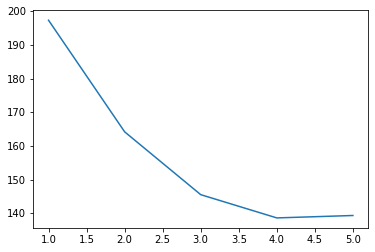

In [20]:
plt.plot(range(1, n_trained_epochs+1), train_avg_loss, label="train loss")
plt.plot(range(1, n_trained_epochs+1), val_avg_loss, label="val loss")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train Loss")
plt.legend(loc="best")
plt.show()

In [ ]:
plt.plot(range(1, n_trained_epochs+1), train_avg_acc, label="train acc")
plt.plot(range(1, n_trained_epochs+1), val_avg_acc, label="val acc")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train/val Accuracy")
plt.legend(loc="best")
plt.show()

## Evaluation on the test dataset

In [ ]:

############ test eval metrics ######################
test_true_labels = []
test_predict_labels = []
test_loss = []
test_acc = []
test_prec = []
test_rec = []
test_f1 = []

########################################################
for batch in tqdm(test_loader):
    batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
    t_input_ids, t_input_mask, t_token_type_ids, t_labels, t_bio_tags = batch     # unpack inputs from dataloader


    # crf in model requires to start with a positive mask label => ignore first token [CLS]
    t_mask_tags_without_CLS = torch.cat([t_bio_tags[i][1:] != -100 for i in range(len(t_bio_tags))]).view(t_bio_tags.shape[0],-1).byte() # byte() casts boolean tensor to tensor with 1 and 0         
    t_bio_tags_without_CLS = torch.cat([t_bio_tags[i][1:] for i in range(len(t_bio_tags))]).view(t_bio_tags.shape[0],-1)

    with torch.no_grad(): # tell model not to compute or store gradients -> saves memory + speeds up validation
        model.eval() # put model in evaluation mode for validation set
        #logits = model(**{"input_ids":v_input_ids, "attention_mask":v_input_mask, "token_type_ids":v_token_type_ids}) # forward pass, calculates logit predictions
        log_likelihood, sequence_of_tags = model(**{"input_ids":t_input_ids
                                                , "attention_mask":t_input_mask
                                                , "token_type_ids":t_token_type_ids
                                                , "tags": t_bio_tags
                                                , "mask_tags_without_CLS":t_mask_tags_without_CLS}) # forward pass, calculates logit predictions

    ######################################################

    t_loss = -1 * log_likelihood            
    test_loss.append(t_loss.item())

    #########################################################

    # calculate performance measures only on tokens and not subwords or special tokens                        
    t_bio_tags_without_CLS = t_bio_tags_without_CLS.detach().to("cpu").numpy()
    t_mask_tags_without_CLS = t_mask_tags_without_CLS.detach().to("cpu").numpy()

    true_tags = t_bio_tags_without_CLS[t_mask_tags_without_CLS.astype(bool)] # get Bio tags for tokens only
    pred = [item for elem in sequence_of_tags for item in elem] # flatten list of lists

    test_true_labels.append(true_tags) # appends true labels for batch
    test_predict_labels.append(pred) # # appends predicted labels for batch
    
    metrics = compute_metrics(pred, true_tags)
    test_acc.append(metrics["accuracy"])
    test_prec.append(metrics["precision"])
    test_rec.append(metrics["recall"])
    test_f1.append(metrics["f1"])


print(F'\n\tTest Loss: {np.mean(test_loss)}')
print(F'\n\tTest acc: {np.mean(test_acc)}')
print(F'\n\tTest prec: {np.mean(test_prec)}')
print(F'\n\tTest rec: {np.mean(test_rec)}')
print(F'\n\tTest f1: {np.mean(test_f1)}')


### Classification reports

In [ ]:

test_true_tag = [id2tag[ID] for ID in np.concatenate(test_true_labels)]#
test_predict_tag = [id2tag[ID] for ID in np.concatenate(test_predict_labels)]
print(classification_report(test_true_tag, test_predict_tag))

In [ ]:
#The metrics we are seeing in this report are designed specifically for NLP tasks such as NER and POS tagging,
#in which all words of an entity need to be predicted correctly to be counted as one correct prediction. 
#Therefore, the metrics in this classification report are much lower than in scikit-learn's classification report.
test_true_tag = [[id2tag[ID] for ID in IDS] for IDS in test_true_labels]
test_predict_tag = [[id2tag[ID] for ID in IDS] for IDS in test_predict_labels]
print(classification_report_seqeval(test_true_tag, test_predict_tag))

### Example: see predictions

In [ ]:
# take last batch of test set:
t_input_ids, t_input_mask, t_token_type_ids, t_labels, t_bio_tags = batch 

for i in range(len(batch)):
    tags_mask = t_bio_tags[i].to("cpu").numpy() != -100 # only get token labels and not labels from subwords or special tokens
    pred = np.argmax(logits[i], axis=1)[tags_mask]
    true_tags = t_bio_tags[i][tags_mask].to("cpu").numpy()    
    

    tokens = tokenizer.convert_ids_to_tokens(t_input_ids[i])

    print("\n\nPadded Sentence:")
    print(tokens)
    print("true labels:")
    print(t_bio_tags[i], "-> ", id2tag[t_bio_tags[i]])
    for token, true_label, pred in zip(np.array(tokens)[tags_mask], true_tags, pred):
        print(token, "\t\ttrue:", true_label, "  pred:", pred)

    
    break


